In [299]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.multivariate.manova import MANOVA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import shapiro
import pandas as pd
from scipy.stats import levene, bartlett


In [300]:
data = pd.read_csv('/Users/manraj/Desktop/Coswara-Data/librosa_features.csv',index_col=0)

## Column mapping for the coulumn names

In [301]:
column_mapping = {
    'User ID': 'user_id',
    'Age (number)': 'age',
    'Cold  (True/False)': 'cold',
    'Date when the user recorded and submitted the samples': 'sample_date',
    'Cough (True/False)': 'cough',
    'Health status (e.g. : positive_mild, healthy,etc.)': 'health_status',
    'Date of CT-Scan': 'ct_scan_date',
    'CT-Scan (y/n if the user has taken a test)': 'ct_scan',
    'CT-Score': 'ct_score',
    'dT': 'dt',
    'Diabetes  (True/False)': 'diabetes',
    'Diarrheoa (True/False)': 'diarrhea',
    'Proficient in English (y/n)': 'english_proficient',
    'fV': 'fv',
    'Fever (True/False)': 'fever',
    'Gender (male/female/other)': 'gender',
    'Hypertension  (True/False)': 'hypertension',
    'Country': 'country',
    'Locality': 'locality',
    'State': 'state',
    'Loss of Smell & Taste (True/False)': 'loss_of_smell_taste',
    'Muscle Pain (True/False)': 'muscle_pain',
    'Returning User (y/n)': 'returning_user',
    'Smoker (True/False)': 'smoker',
    'Type of test (RAT/RT-PCR)': 'test_type',
    'Date of COVID Test (if taken)': 'covid_test_date',
    'Status of COVID Test (p->Positive, n->Negative, na-> Not taken Test)': 'covid_test_status',
    'Using Mask (y/n)': 'mask_usage',
    'Vaccination status (y->both doses, p->one dose(partially vaccinated), n->no doses)': 'vaccination_status',
    'Breathing Difficulties (True/False)': 'breathing_difficulties',
    'Respiratory illnesses other than the listed ones (True/False)': 'other_respiratory_illnesses',
    'Fatigue (True/False)': 'fatigue',
    'Sore Throat (True/False)': 'sore_throat',
    'Ischemic Heart Disease (True/False)': 'ischemic_heart_disease',
    'Asthma (True/False)': 'asthma',
    'Pre-existing conditions other than the listed ones (True/False)': 'other_preexisting_conditions',
    'Chronic Lung Disease (True/False)': 'chronic_lung_disease',
    'Pneumonia (True/False)': 'pneumonia',
    'iF': 'if',
    'date': 'date',
    'test': 'test',
}

data = data.rename(columns=column_mapping)

## Creating the age bins

In [302]:
age_bins = [18, 41, 61, 81]
age_labels = ['18-40', '41-60', '61-80']
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

In [303]:
rms_columns = [cols for cols in data.columns if cols.startswith('rms')]
zcr_columns = [cols for cols in data.columns if cols.startswith('zero')]

## Distribution of data by groups

In [304]:
data.groupby(['gender','age_group','health_status']).size().unstack(fill_value=0)

health_status     Illness Not Identified  Negative  Positive
gender age_group                                            
Female 18-40                          43       373       146
       41-60                          19       108        78
       61-80                           5        17        34
Male   18-40                         116       968       245
       41-60                          29       284       113
       61-80                          18        36        42
Other  18-40                           0         0         0
       41-60                           0         0         0
       61-80                           0         0         1

In [305]:
data.groupby(['cough','health_status']).size().unstack(fill_value=0)

health_status,Illness Not Identified,Negative,Positive
cough,,,
False,152,1656,286
True,86,171,395


In [306]:
data = data.loc[(data['gender'] != 'Other') & (data['age_group'] != '61-80') & (data['health_status'] != 'Illness Not Identified')]

In [307]:
data.groupby(['gender','health_status','age_group']).size().unstack(fill_value=0)

age_group             18-40  41-60  61-80
gender health_status                     
Female Negative         373    108      0
       Positive         146     78      0
Male   Negative         968    284      0
       Positive         245    113      0

In [308]:
columns_to_test = ['gender', 'health_status', 'cold', 'cough', 'diabetes', 'fever', 
                   'hypertension', 'loss_of_smell_taste', 'muscle_pain', 'smoker',
                   'breathing_difficulties', 'other_respiratory_illnesses', 'fatigue', 
                   'sore_throat', 'ischemic_heart_disease', 'asthma', 
                   'other_preexisting_conditions', 'chronic_lung_disease', 'pneumonia','age_group']

significant_results = []

for col in columns_to_test:
    contingency_table = pd.crosstab(data['health_status'], data[col])
    if (contingency_table >= 20).all().all():
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if p < 0.05: 
                significant_results.append((col, chi2, p))

significant_results_df = pd.DataFrame(significant_results, columns=['Variable', 'Chi2', 'p-value'])
significant_results_df

,Variable,Chi2,p-value
0,gender,24.403930,7.810919e-07
1,cold,397.979832,1.516012e-88
2,cough,625.423268,4.945660e-138
3,diabetes,46.048084,1.153860e-11
4,fever,593.324262,4.740658e-131
5,hypertension,21.669987,3.238182e-06
6,loss_of_smell_taste,227.697437,1.894541e-51
7,muscle_pain,482.023627,7.751914e-107
8,breathing_difficulties,133.484181,7.084495e-31
9,fatigue,540.481173,1.481680e-119


## Chi Square Test

In [309]:
columns_to_test = ['health_status', 'cold', 'cough', 'loss_of_smell_taste','fatigue']

significant_results = []

for i in range(len(columns_to_test)):
    for j in range(i+1, len(columns_to_test)):
        col1 = columns_to_test[i]
        col2 = columns_to_test[j]
        
        contingency_table = pd.crosstab(data[col1], data[col2])
        
        if (contingency_table >= 20).all().all():
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if p < 0.05: 
                significant_results.append((col1, col2, chi2, p))

significant_results_df = pd.DataFrame(significant_results, columns=['Variable 1', 'Variable 2', 'Chi2', 'p-value'])

significant_results_df = significant_results_df.sort_values(by='p-value')
significant_results_df

,Variable 1,Variable 2,Chi2,p-value
1,health_status,cough,625.423268,4.945660e-138
4,cold,cough,611.065753,6.560637e-135
3,health_status,fatigue,540.481173,1.481680e-119
8,cough,fatigue,414.347253,4.148138e-92
0,health_status,cold,397.979832,1.516012e-88
6,cold,fatigue,247.984382,7.142816e-56
2,health_status,loss_of_smell_taste,227.697437,1.894541e-51
9,loss_of_smell_taste,fatigue,177.791850,1.470839e-40
7,cough,loss_of_smell_taste,165.187466,8.324507e-38
5,cold,loss_of_smell_taste,162.853101,2.693478e-37


In [310]:
pd.crosstab(data['health_status'], data['cough'])

cough,False,True
health_status,,
Negative,1611,162
Positive,256,348


In [311]:
columns_to_test = ['gender', 'health_status', 'cold', 'cough', 'diabetes', 'fever', 
                   'hypertension', 'loss_of_smell_taste', 'muscle_pain', 'smoker',
                   'breathing_difficulties', 'other_respiratory_illnesses', 'fatigue', 
                   'sore_throat', 'ischemic_heart_disease', 'asthma', 
                   'other_preexisting_conditions', 'chronic_lung_disease', 'pneumonia', 'age_group']

significant_results = []

for i in range(len(columns_to_test)):
    for j in range(i+1, len(columns_to_test)):
        col1 = columns_to_test[i]
        col2 = columns_to_test[j]
        
        contingency_table = pd.crosstab(data[col1], data[col2])
        
        if (contingency_table >= 20).all().all():
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if p < 0.05:  
                significant_results.append((col1, col2, chi2, p))

significant_results_df = pd.DataFrame(significant_results, columns=['Variable 1', 'Variable 2', 'Chi2', 'p-value'])

significant_results_df

,Variable 1,Variable 2,Chi2,p-value
0,gender,health_status,24.403930,7.810919e-07
1,gender,cold,13.802429,2.030736e-04
2,gender,cough,18.792675,1.457258e-05
3,gender,fever,17.826069,2.420443e-05
4,gender,loss_of_smell_taste,8.393182,3.766309e-03
5,gender,muscle_pain,22.235062,2.412282e-06
6,gender,fatigue,19.056663,1.268940e-05
7,gender,sore_throat,12.908689,3.270603e-04
8,gender,other_preexisting_conditions,16.587856,4.644749e-05
9,health_status,cold,397.979832,1.516012e-88


## Conducting T Test

In [312]:
from scipy.stats import ttest_1samp, ttest_ind

Making groups 

In [313]:
Grupo1MALE1840positive = data['rms_cough_heavy'].loc[(data['health_status']=='Positive') & (data['gender']=='Male') & (data['age_group']=='18-40')]
Grupo2MALE1840negative = data['rms_cough_heavy'].loc[(data['health_status']=='Negative') & (data['gender']=='Male') & (data['age_group']=='18-40')]

Grupo1MALE4160positive = data['rms_cough_heavy'].loc[(data['health_status']=='Positive') & (data['gender']=='Male') & (data['age_group']=='41-60')]
Grupo2MALE4160negative = data['rms_cough_heavy'].loc[(data['health_status']=='Negative') & (data['gender']=='Male') & (data['age_group']=='41-60')]


Grupo1MALE1840positive = Grupo1MALE1840positive.dropna()
Grupo2MALE1840negative = Grupo2MALE1840negative.dropna()
Grupo1MALE4160positive = Grupo1MALE4160positive.dropna()
Grupo2MALE4160negative = Grupo2MALE4160negative.dropna()

In [314]:
Grupo1FEMALE1840positive = data['rms_cough_heavy'].loc[(data['health_status']=='Positive') & (data['gender']=='Female') & (data['age_group']=='18-40')]
Grupo2FEMALE1840negative = data['rms_cough_heavy'].loc[(data['health_status']=='Negative') & (data['gender']=='Female') & (data['age_group']=='18-40')]
Grupo1FEMALE4160positive = data['rms_cough_heavy'].loc[(data['health_status']=='Positive') & (data['gender']=='Female') & (data['age_group']=='41-60')]
Grupo2FEMALE4160negative = data['rms_cough_heavy'].loc[(data['health_status']=='Negative') & (data['gender']=='Female') & (data['age_group']=='41-60')]


Grupo1FEMALE1840positive = Grupo1FEMALE1840positive.dropna()
Grupo2FEMALE1840negative = Grupo2FEMALE1840negative.dropna()
Grupo1FEMALE4160positive = Grupo1FEMALE4160positive.dropna()
Grupo2FEMALE4160negative = Grupo2FEMALE4160negative.dropna()

For group of male age 18-40 positive and negative

In [315]:
t_stat_1, p_value_1 = ttest_ind(Grupo1MALE1840positive, Grupo2MALE1840negative)

round(p_value_1,2)

0.05

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

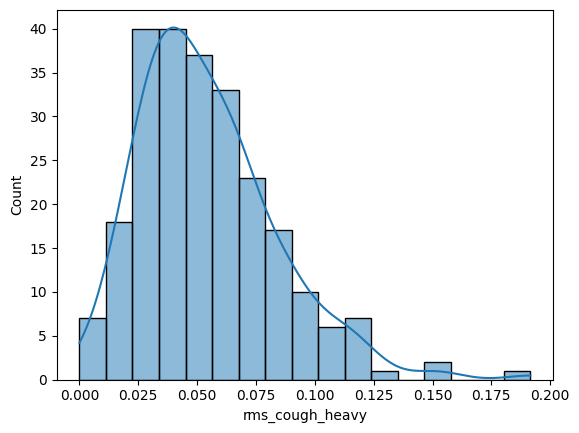

In [316]:
sns.histplot(Grupo1MALE1840positive,kde=True)

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

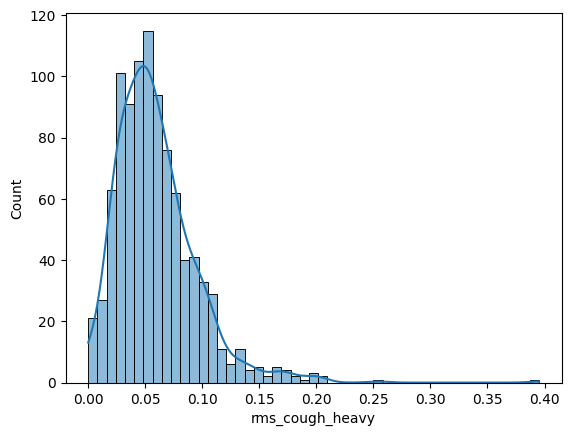

In [317]:
sns.histplot(Grupo2MALE1840negative,kde=True)

In [318]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(Grupo1MALE1840positive, Grupo2MALE1840negative)

round(p_value,2)

0.1

Removing the outliers

In [319]:
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

Grupo1MALE1840positive_no_outliers = remove_outliers_iqr(Grupo1MALE1840positive)
Grupo2MALE1840negative_no_outliers = remove_outliers_iqr(Grupo2MALE1840negative)
Grupo1MALE4160positive_no_outliers = remove_outliers_iqr(Grupo1MALE4160positive)
Grupo2MALE4160negative_no_outliers = remove_outliers_iqr(Grupo2MALE4160negative)

For group of male age 18-40 positive and negative without outliers

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

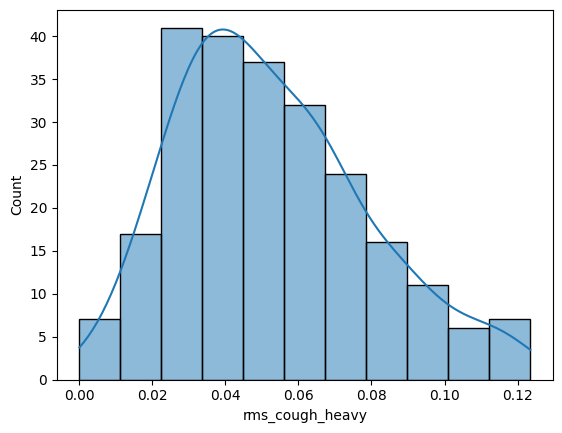

In [320]:
sns.histplot(Grupo1MALE1840positive_no_outliers,kde=True)

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

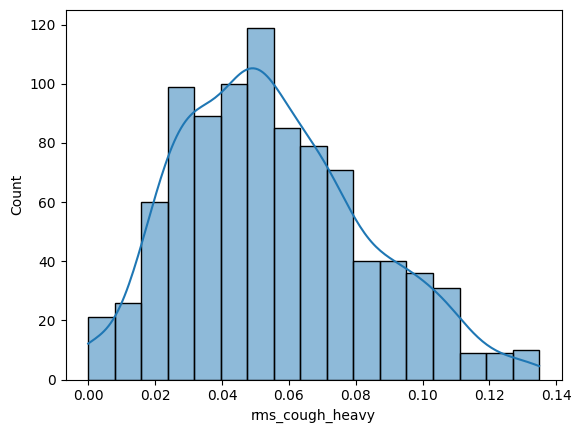

In [321]:
sns.histplot(Grupo2MALE1840negative_no_outliers,kde=True)

In [322]:
t_stat_1, p_value_1 = ttest_ind(Grupo1MALE1840positive_no_outliers, Grupo2MALE1840negative_no_outliers)

round(p_value,2)

0.1

In [323]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(Grupo1MALE1840positive_no_outliers, Grupo2MALE1840negative_no_outliers)

round(p_value, 2)

0.21

For group of Female age 18-40 positive and negative

In [324]:
t_stat_1, p_value_1 = ttest_ind(Grupo1FEMALE1840positive, Grupo2FEMALE1840negative)

round(p_value_1,2)

0.42

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

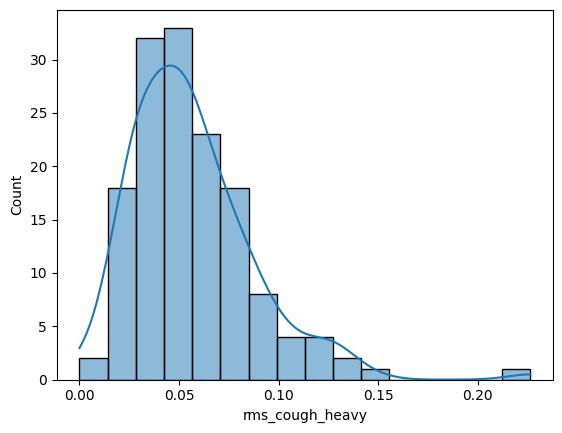

In [325]:
sns.histplot(Grupo1FEMALE1840positive,kde=True)

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

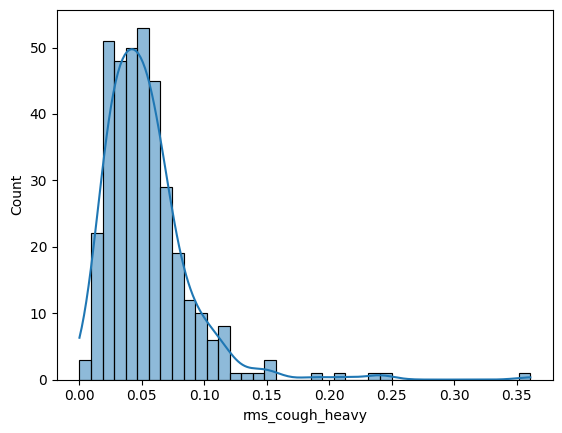

In [326]:
sns.histplot(Grupo2FEMALE1840negative,kde=True)

Removing the outliers

In [327]:
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

Grupo1FEMALE1840positive_no_outliers = remove_outliers_iqr(Grupo1FEMALE1840positive)
Grupo2FEMALE1840negative_no_outliers = remove_outliers_iqr(Grupo2FEMALE1840negative)
Grupo1FEMALE4160positive_no_outliers = remove_outliers_iqr(Grupo1FEMALE4160positive)
Grupo2FEMALE4160negative_no_outliers = remove_outliers_iqr(Grupo2FEMALE4160negative)

In [328]:
t_stat_1, p_value_1 = ttest_ind(Grupo1FEMALE1840positive_no_outliers, Grupo2FEMALE1840negative_no_outliers)

round(p_value_1,2)

0.01

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

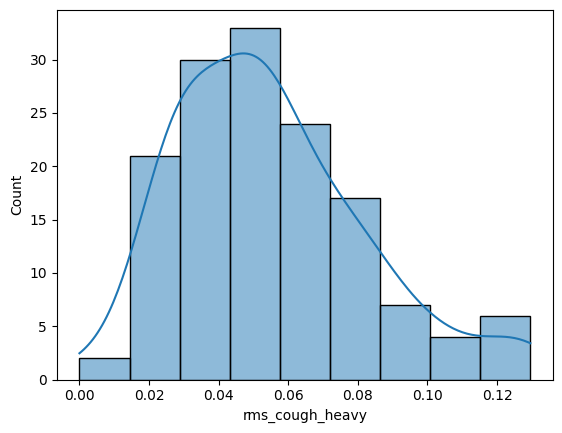

In [329]:
sns.histplot(Grupo1FEMALE1840positive_no_outliers,kde=True)

<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

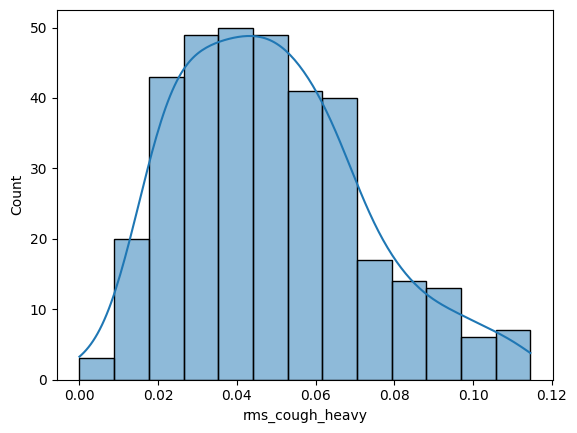

In [330]:
sns.histplot(Grupo2FEMALE1840negative_no_outliers,kde=True)

In [331]:
FEMALE1840 = pd.concat([Grupo1FEMALE1840positive_no_outliers, Grupo2FEMALE1840negative_no_outliers], ignore_index=True)


<Axes: xlabel='rms_cough_heavy', ylabel='Count'>

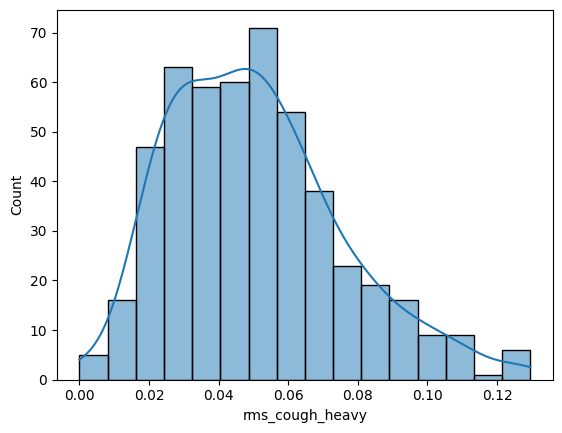

In [332]:
sns.histplot(FEMALE1840,kde=True)

In [333]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(Grupo1FEMALE1840positive_no_outliers, Grupo2FEMALE1840negative_no_outliers)

round(p_value, 2)

0.04

## Anova test 

We defined the coulmns that were significat for the analysis

In [334]:
important_columns = ['rms_cough_heavy','rms_cough_shallow','zero_crossing_rate_counting_normal','zero_crossing_rate_counting_fast','rms_vowel_a','zero_crossing_rate_vowel_a']

In [335]:
significant_results_list = []

for col in important_columns:
    formula = f'{col} ~ C(gender) + C(health_status) + C(age_group) + C(gender):C(health_status) + C(gender):C(age_group) + C(health_status):C(age_group) + C(gender):C(health_status):C(age_group)'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    anova_table['Variable'] = col
    
    significant_results_list.append(anova_table)

significant_results_df = pd.concat(significant_results_list)

significant_results_df.reset_index(inplace=True)

columns_order = ['Variable'] + [col for col in significant_results_df.columns if col not in ['Variable', 'Column Name']]
significant_results_df = significant_results_df[columns_order]
significant_results_df.loc[significant_results_df['PR(>F)']<0.05]

,Variable,index,sum_sq,df,F,PR(>F)
2,rms_cough_heavy,C(age_group),0.010655,2.0,4.600946,0.032060
6,rms_cough_heavy,C(gender):C(health_status):C(age_group),0.014111,2.0,6.092949,0.013645
10,rms_cough_shallow,C(age_group),0.033025,2.0,18.373837,0.000019
13,rms_cough_shallow,C(health_status):C(age_group),0.008472,2.0,4.713547,0.030029
14,rms_cough_shallow,C(gender):C(health_status):C(age_group),0.009343,2.0,5.198386,0.022700
20,zero_crossing_rate_counting_normal,C(gender):C(age_group),0.012714,2.0,6.380052,0.011608
28,zero_crossing_rate_counting_fast,C(gender):C(age_group),0.009609,2.0,7.112086,0.007711
34,rms_vowel_a,C(age_group),0.068002,2.0,6.904765,0.008654


In [336]:
numerical_columns = [col for col in data.select_dtypes(['int64','float64']) if col not in ['min_cough_heavy',
 'max_cough_heavy',
 'min_cough_shallow',
 'max_cough_shallow',
 'min_counting_fast',
 'max_counting_fast',
 'min_counting_normal',
 'max_counting_normal',
 'min_breathing_deep',
 'max_breathing_deep',
 'min_breathing_shallow',
 'max_breathing_shallow',
 'min_vowel_a',
 'max_vowel_a',
 'min_vowel_e',
 'max_vowel_e',
 'min_vowel_o',
 'max_vowel_o',
 'FILENAME',
 ' QUALITY',
 'FILENAME_vowel-o_labels',
 ' QUALITY_vowel-o_labels',
 'FILENAME_counting-fast_labels',
 ' QUALITY_counting-fast_labels',
 'FILENAME_vowel-e_labels',
 ' QUALITY_vowel-e_labels',
 'FILENAME_breathing-deep_labels',
 ' QUALITY_breathing-deep_labels',
 'FILENAME_breathing-shallow_labels',
 ' QUALITY_breathing-shallow_labels',
 'FILENAME_counting-normal_labels',
 ' QUALITY_counting-normal_labels',
 'FILENAME_cough-heavy_labels',
 ' QUALITY_cough-heavy_labels',
 'FILENAME_vowel-a_labels',
 ' QUALITY_vowel-a_labels','age','fv']]


In [337]:
normality_results = {}

for col in important_columns:
    
    stat, p_value = shapiro(data[col].dropna())
    
    is_normal = p_value > 0.05
    
    normality_results[col] = {
        'Shapiro-Wilk Statistic': stat,
        'p-value': p_value,
        'Normal Distribution': is_normal
    }

normality_df = pd.DataFrame(normality_results).T
normality_df

,Shapiro-Wilk Statistic,p-value,Normal Distribution
rms_cough_heavy,0.881845,0.0,False
rms_cough_shallow,0.827275,0.0,False
zero_crossing_rate_counting_normal,0.708694,0.0,False
zero_crossing_rate_counting_fast,0.746231,0.0,False
rms_vowel_a,0.944696,0.0,False
zero_crossing_rate_vowel_a,0.711047,0.0,False


In [338]:
group_columns = ['gender', 'health_status', 'age_group']

def perform_tests(column, group_cols, data):
    grouped = data.groupby(group_cols)
    
    group_data = [group[column].dropna() for _, group in grouped]
    
    if len(group_data) < 2:
        return {
            'Column': column,
            'Levene’s Test Statistic': None,
            'Levene’s p-value': None,
            'Bartlett’s Test Statistic': None,
            'Bartlett’s p-value': None,
            'Reason': 'Not enough groups'
        }

    try:
        levene_stat, levene_p_value = levene(*group_data)
    except ValueError:
        levene_stat, levene_p_value = None, None

    try:
        bartlett_stat, bartlett_p_value = bartlett(*group_data)
    except ValueError:
        bartlett_stat, bartlett_p_value = None, None

    return {
        'Column': column,
        'Levene’s Test Statistic': levene_stat,
        'Levene’s p-value': levene_p_value,
    }

results = []
for col in important_columns:
    result = perform_tests(col, group_columns, data)
    results.append(result)

results_df = pd.DataFrame(results)
results_df

,Column,Levene’s Test Statistic,Levene’s p-value
0,rms_cough_heavy,0.943097,0.471750
1,rms_cough_shallow,1.461245,0.176606
2,zero_crossing_rate_counting_normal,2.751183,0.007588
3,zero_crossing_rate_counting_fast,1.532748,0.151506
4,rms_vowel_a,2.230948,0.029240
5,zero_crossing_rate_vowel_a,1.326951,0.233179


In [339]:
import pandas as pd
from scipy.stats import kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols


def perform_kruskal_wallis(column, group_col, data):
    grouped = data.groupby(group_col)
    group_data = [group[column].dropna() for _, group in grouped]
    if len(group_data) < 2:
        return {
            'Column': column,
            'Group': group_col,
            'Kruskal-Wallis Statistic': None,
            'p-value': None,
            'Reason': 'Not enough groups'
        }
    stat, p_value = kruskal(*group_data)
    return {
        'Column': column,
        'Group': group_col,
        'Kruskal-Wallis Statistic': stat,
        'p-value': p_value,
    }

kruskal_results = []
for col in important_columns:
    for group_col in group_columns:
        result = perform_kruskal_wallis(col, group_col, data)
        kruskal_results.append(result)



kruskal_results_df = pd.DataFrame(kruskal_results)
kruskal_results_df.loc[kruskal_results_df['p-value']<=0.05]

,Column,Group,Kruskal-Wallis Statistic,p-value
0,rms_cough_heavy,gender,21.497572,3.542769e-06
3,rms_cough_shallow,gender,10.660557,1.094444e-03
7,zero_crossing_rate_counting_normal,health_status,46.201839,1.066768e-11
10,zero_crossing_rate_counting_fast,health_status,55.681593,8.521242e-14
12,rms_vowel_a,gender,6.455922,1.105832e-02
16,zero_crossing_rate_vowel_a,health_status,17.777298,2.483287e-05


In [340]:
def perform_welchs_anova(column, data, group_cols):
    formula = f'{column} ~ C({group_cols[0]}) + C({group_cols[1]}) + C({group_cols[2]}) + C({group_cols[0]}):C({group_cols[1]}):C({group_cols[2]})'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')
    return anova_table


welchs_anova_results = {}
for col in important_columns:
    anova_result = perform_welchs_anova(col, data, group_columns)
    welchs_anova_results[col] = anova_result

welchs_anova_results_df = pd.concat(welchs_anova_results, axis=0)
welchs_anova_results_df.reset_index(inplace=True)
welchs_anova_results_df.columns = ['Column', 'Source', 'Sum of Squares', 'df', 'F', 'PR(>F)']

In [341]:
welchs_anova_results_df.loc[welchs_anova_results_df['PR(>F)']<=0.05]

,Column,Source,Sum of Squares,df,F,PR(>F)
3,rms_cough_heavy,C(gender):C(health_status):C(age_group),0.022736,7.0,2.805012,2.443254e-02
7,rms_cough_shallow,C(age_group),0.057532,2.0,32.008663,1.727683e-08
8,rms_cough_shallow,C(gender):C(health_status):C(age_group),0.019680,7.0,3.128327,1.408945e-02
12,zero_crossing_rate_counting_normal,C(age_group),0.008644,2.0,4.337709,3.738831e-02
13,zero_crossing_rate_counting_normal,C(gender):C(health_status):C(age_group),0.018977,7.0,2.720816,2.815808e-02
18,zero_crossing_rate_counting_fast,C(gender):C(health_status):C(age_group),0.017256,7.0,3.649073,5.716219e-03


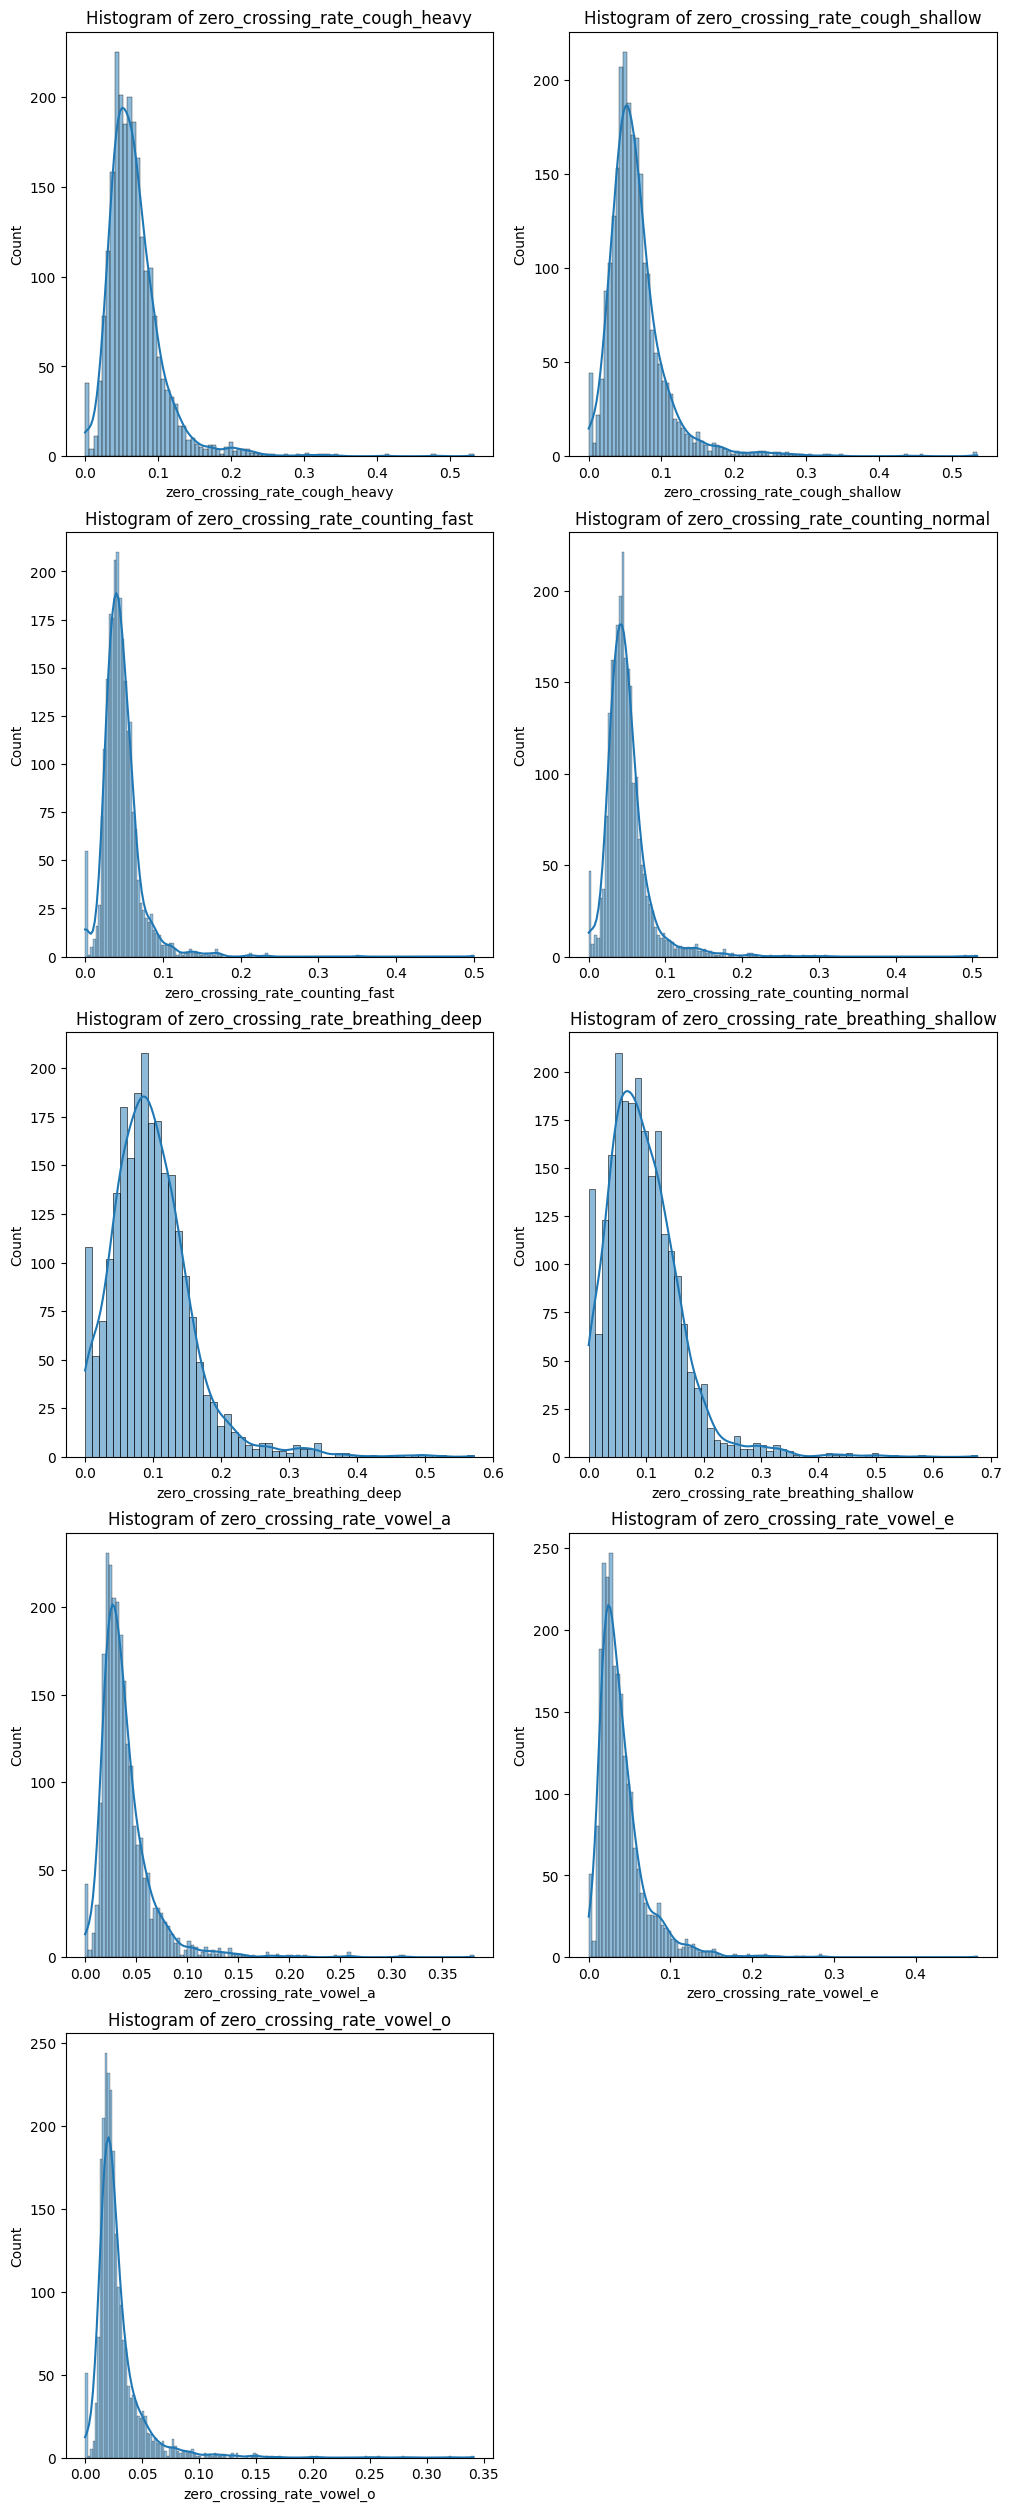

In [342]:
import numpy as np
def plot_histograms(data, columns, col_wrap=2):
    n_cols = col_wrap
    n_rows = int(np.ceil(len(columns) / col_wrap))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)

    for ax, col in zip(axes.flat, columns):
        sns.histplot(data[col], kde=True, multiple='stack', ax=ax, palette="Set2")
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')

    # Hide any empty subplots
    for i in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flat[i])
    
    plt.show()

# Plot histograms for each column
plot_histograms(data, zcr_columns)

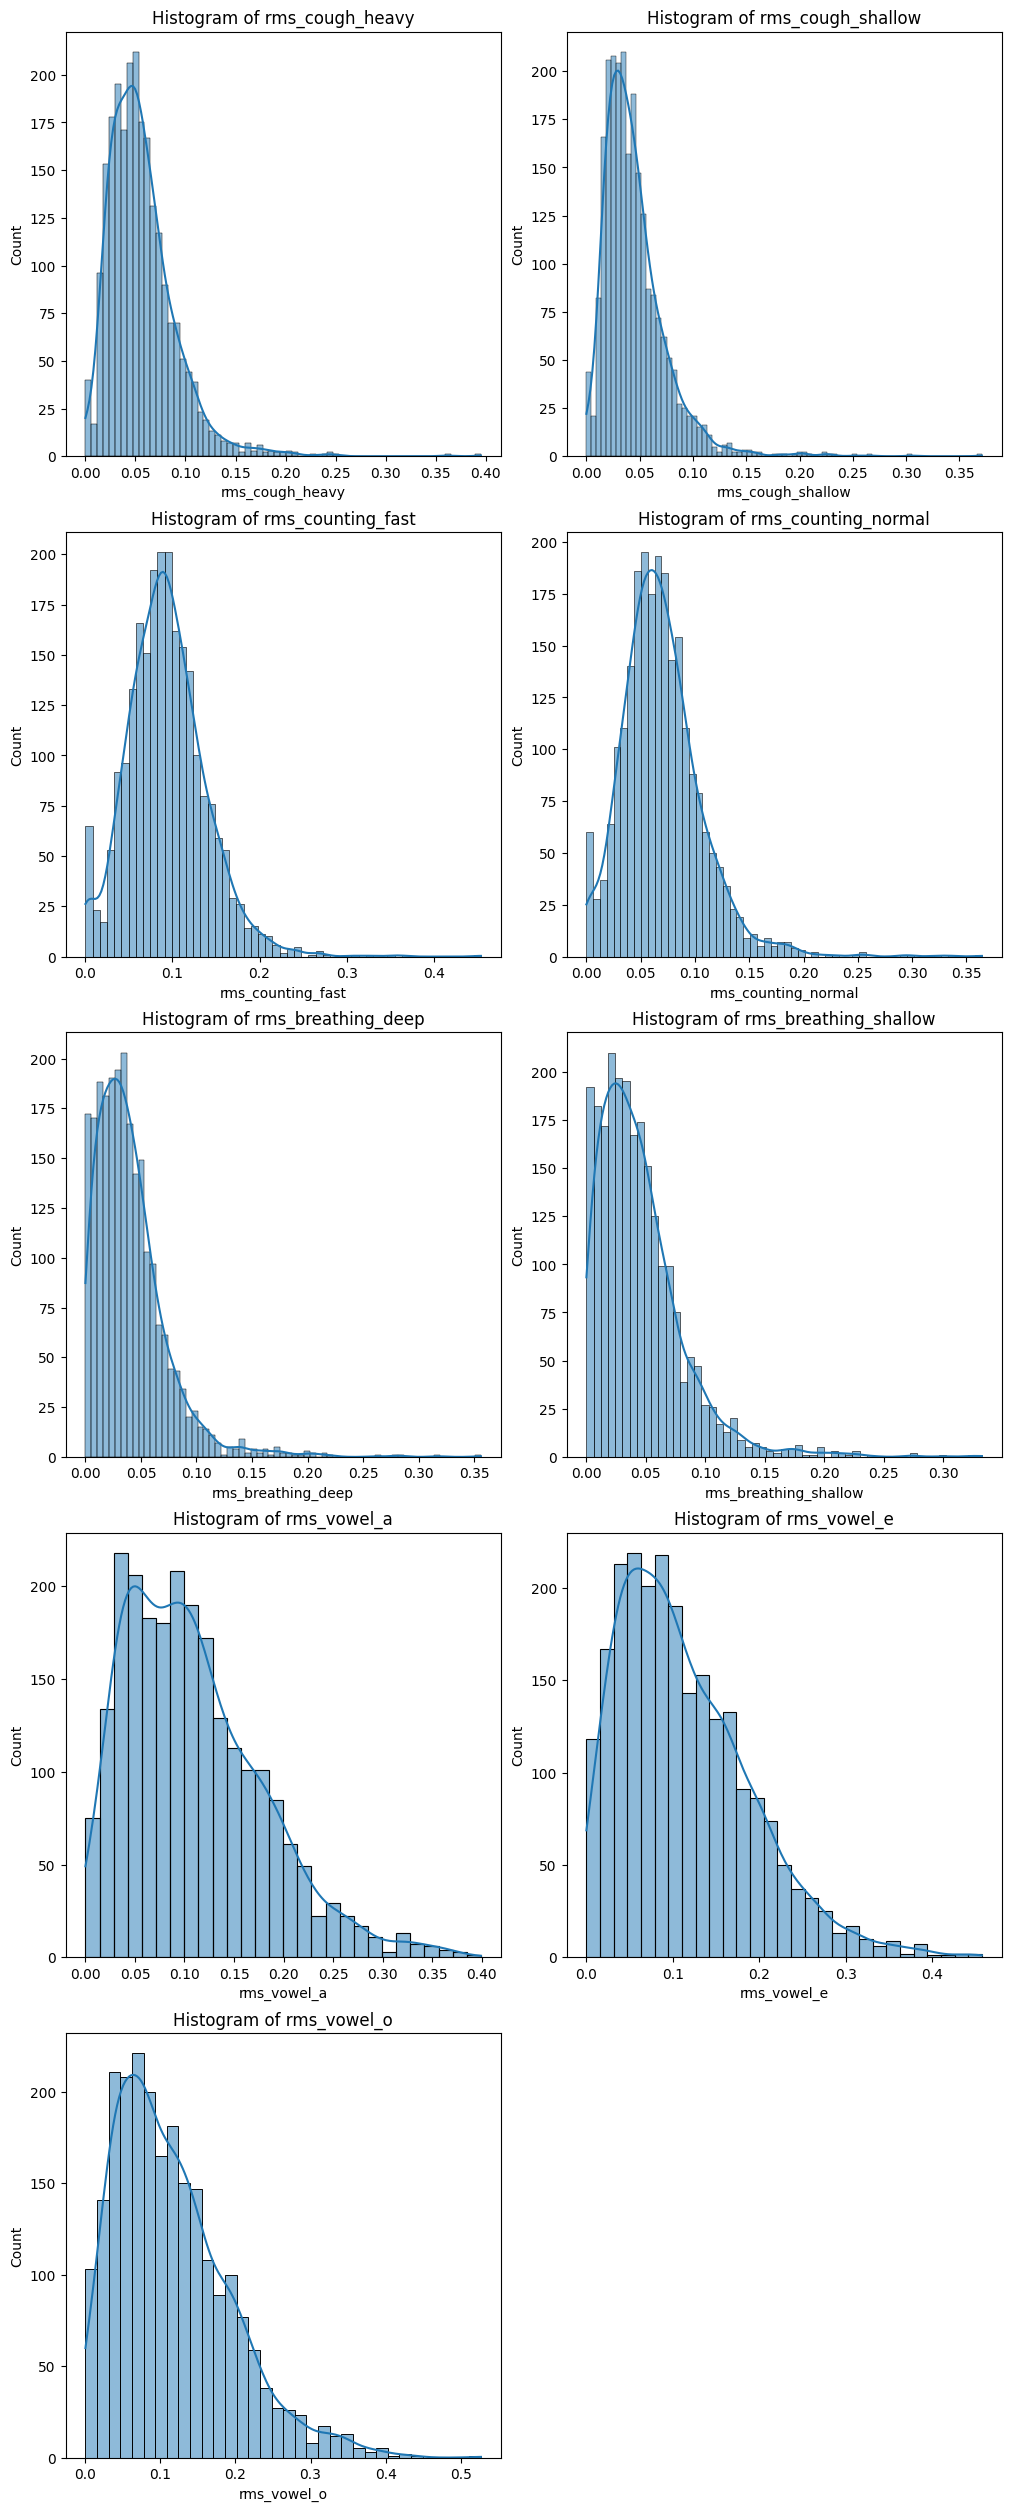

In [343]:
import numpy as np
def plot_histograms(data, columns, col_wrap=2):
    n_cols = col_wrap
    n_rows = int(np.ceil(len(columns) / col_wrap))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)

    for ax, col in zip(axes.flat, columns):
        sns.histplot(data[col], kde=True, multiple='stack', ax=ax, palette="Set2")
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')

    for i in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flat[i])
    
    plt.show()

plot_histograms(data, rms_columns)

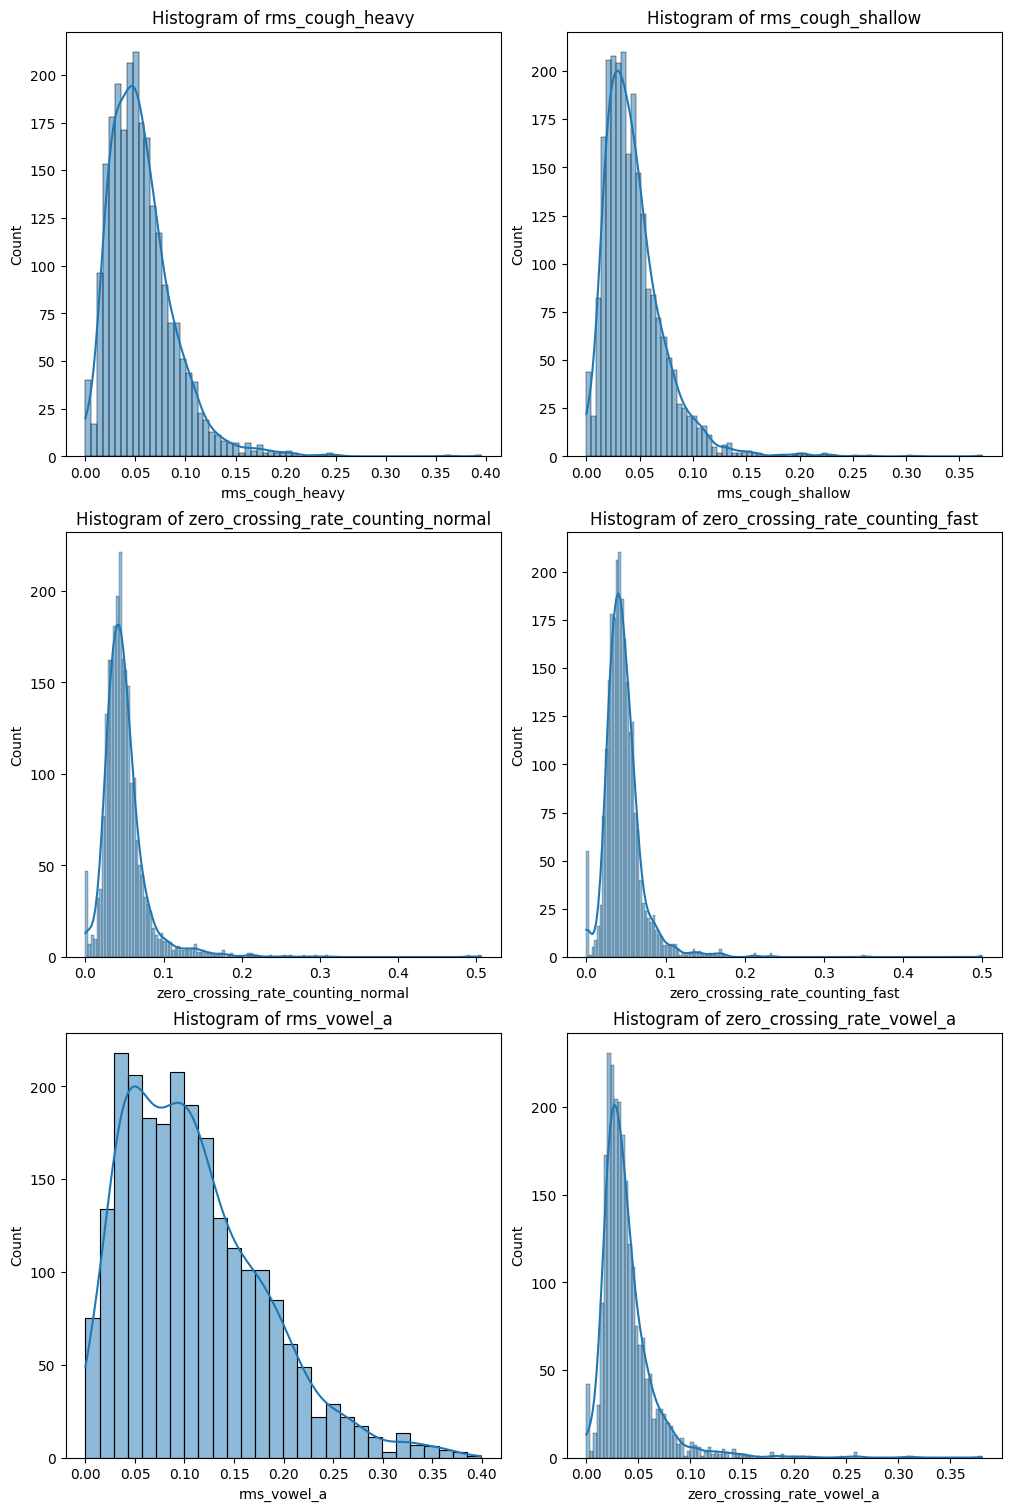

In [344]:
import numpy as np
def plot_histograms(data, columns, col_wrap=2):
    n_cols = col_wrap
    n_rows = int(np.ceil(len(columns) / col_wrap))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), constrained_layout=True)

    for ax, col in zip(axes.flat, columns):
        sns.histplot(data[col], kde=True, multiple='stack', ax=ax, palette="Set2")
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')

    for i in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flat[i])
    
    plt.show()

plot_histograms(data, important_columns)

## Pllotting boxplots by groups

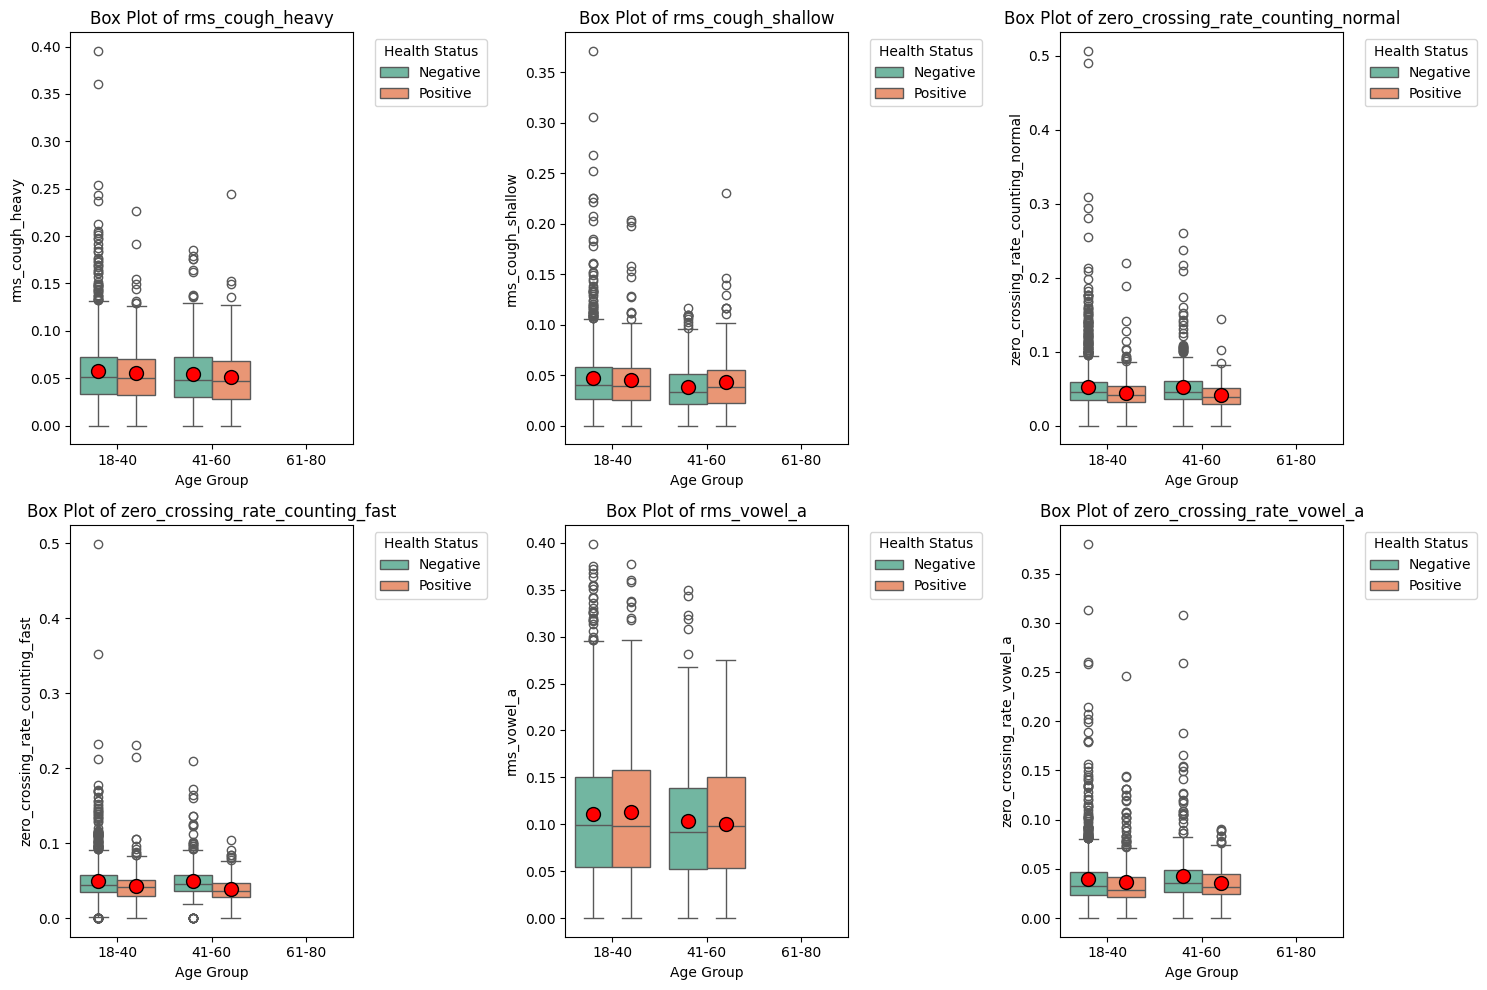

In [345]:
import numpy as np
cols_per_row = 3

num_cols = len(important_columns)
num_rows = int(np.ceil(num_cols / cols_per_row))

fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(15, 5 * num_rows))

axes = axes.flatten()

meanprops = {"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 10}

for i, col in enumerate(important_columns):
    sns.boxplot(data=data, x='age_group', y=col, hue='health_status', palette='Set2', ax=axes[i], showmeans=True, meanprops=meanprops)
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel(col)
    axes[i].legend(title='Health Status', bbox_to_anchor=(1.05, 1), loc='upper left')

    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Pllotting histograms by age group

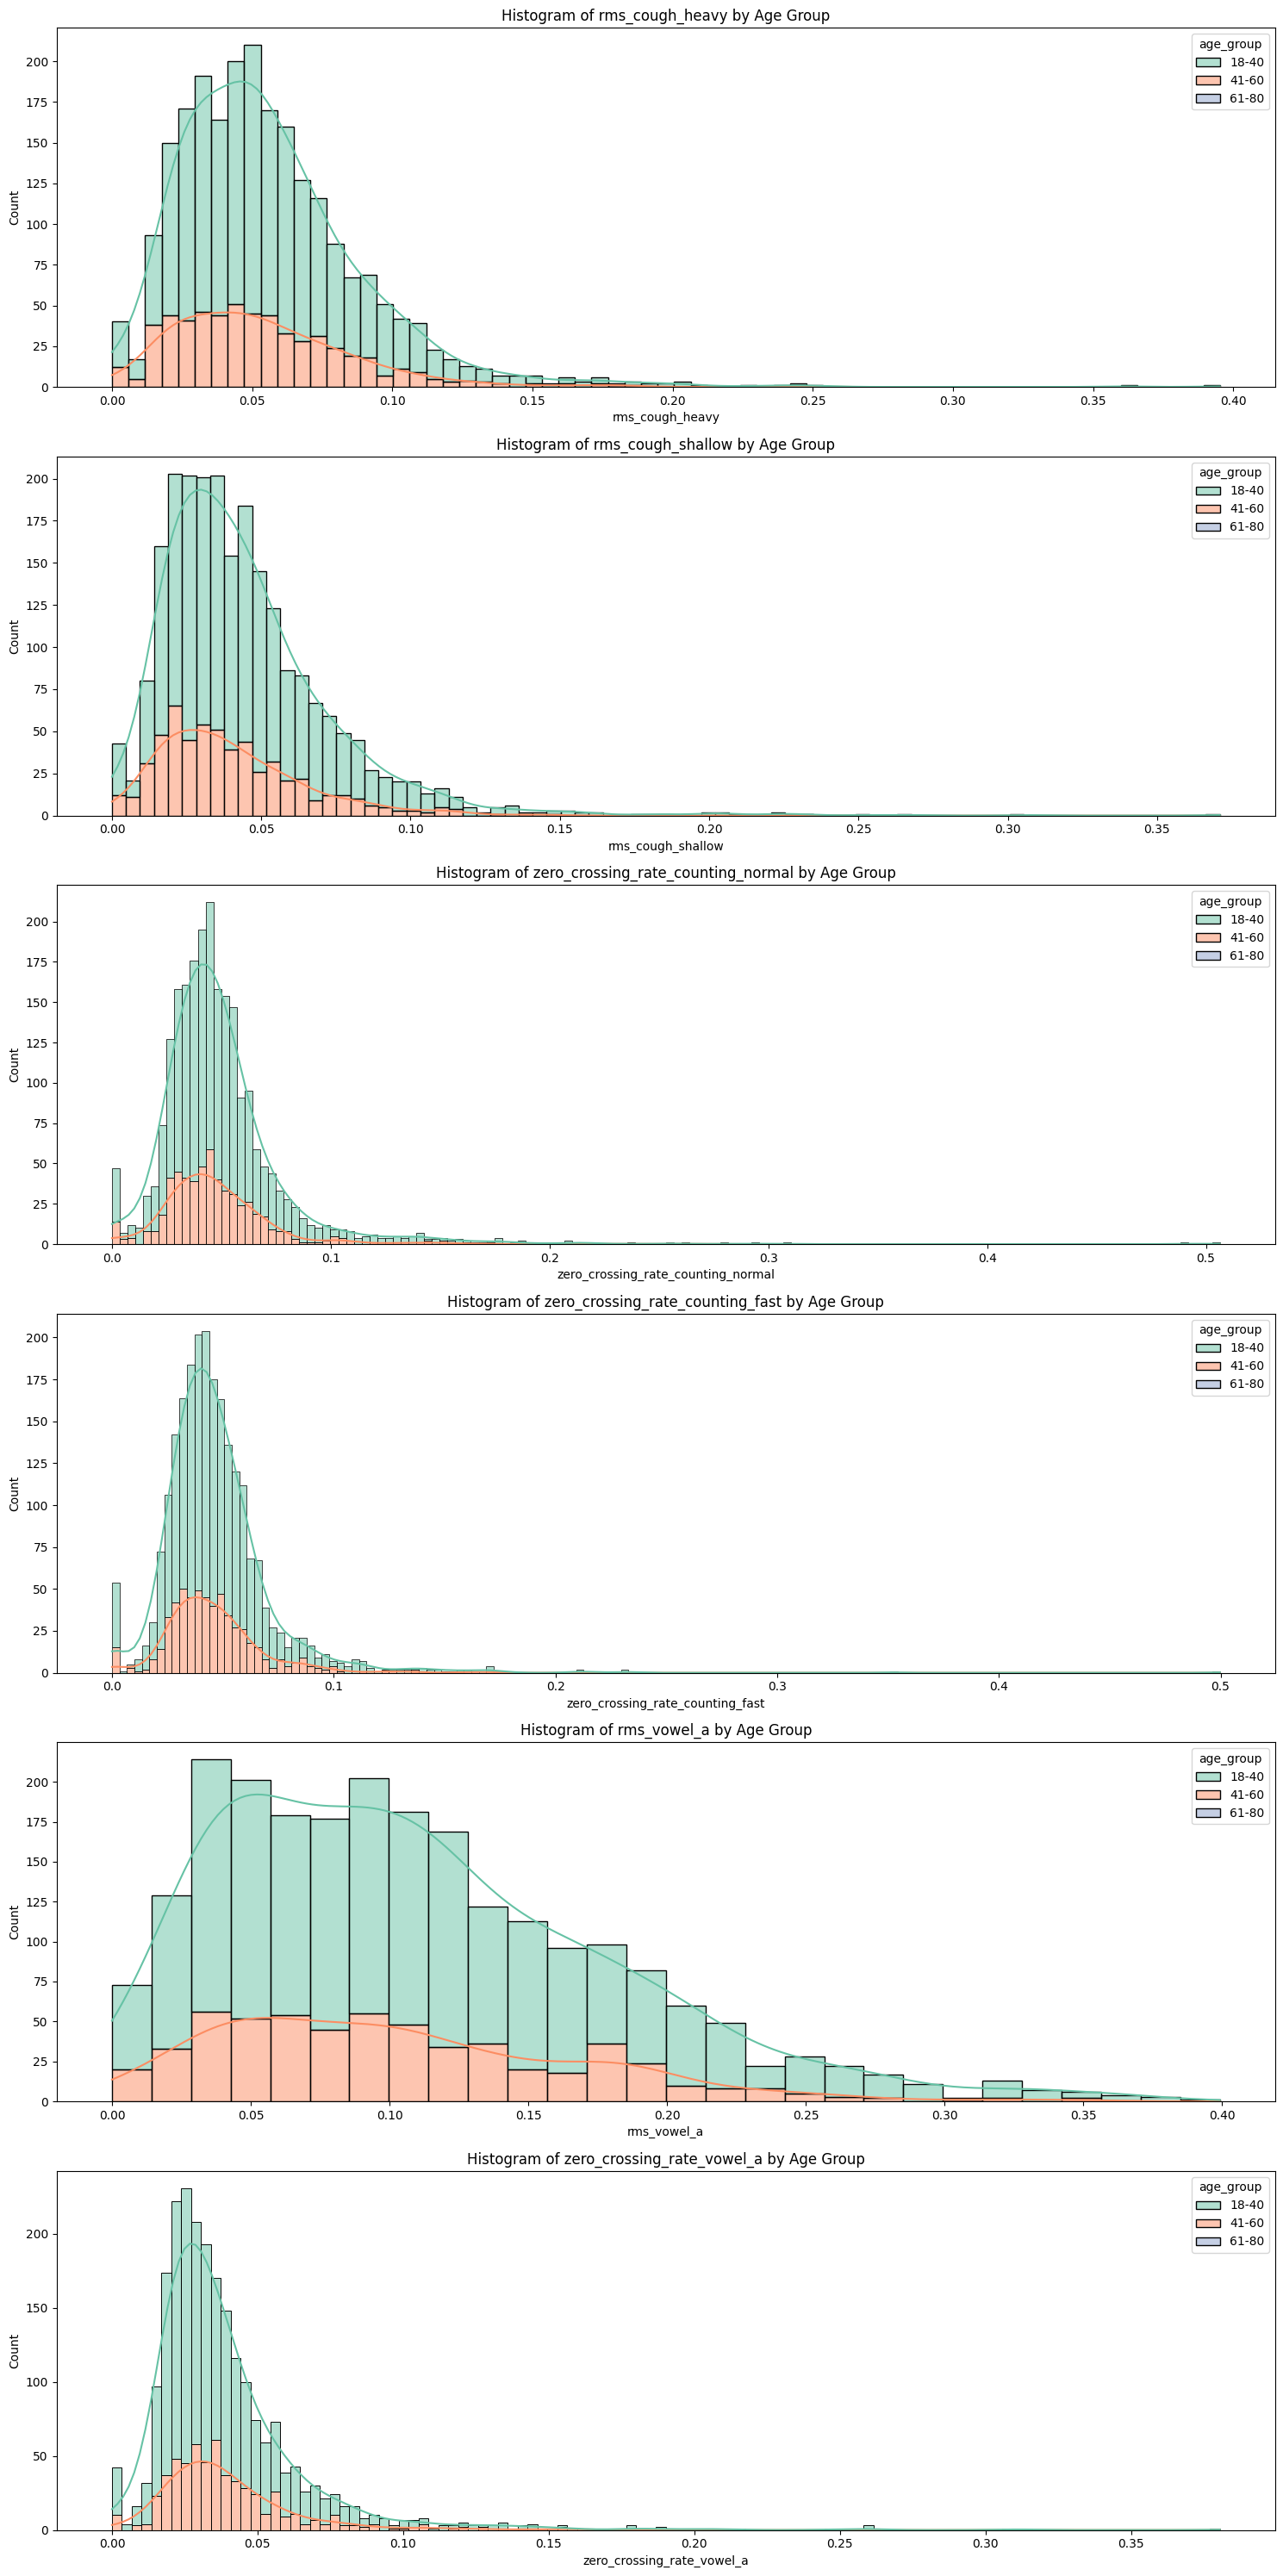

In [346]:
fig, axs = plt.subplots(len(important_columns), 1, figsize=(15, 5 * len(important_columns)))

for i, col in enumerate(important_columns):
    sns.histplot(data, x=col, hue='age_group', multiple='stack', kde=True, palette='Set2', ax=axs[i])
    axs[i].set_title(f'Histogram of {col} by Age Group')

plt.tight_layout()
plt.show()

## Pllotting histograms by groups

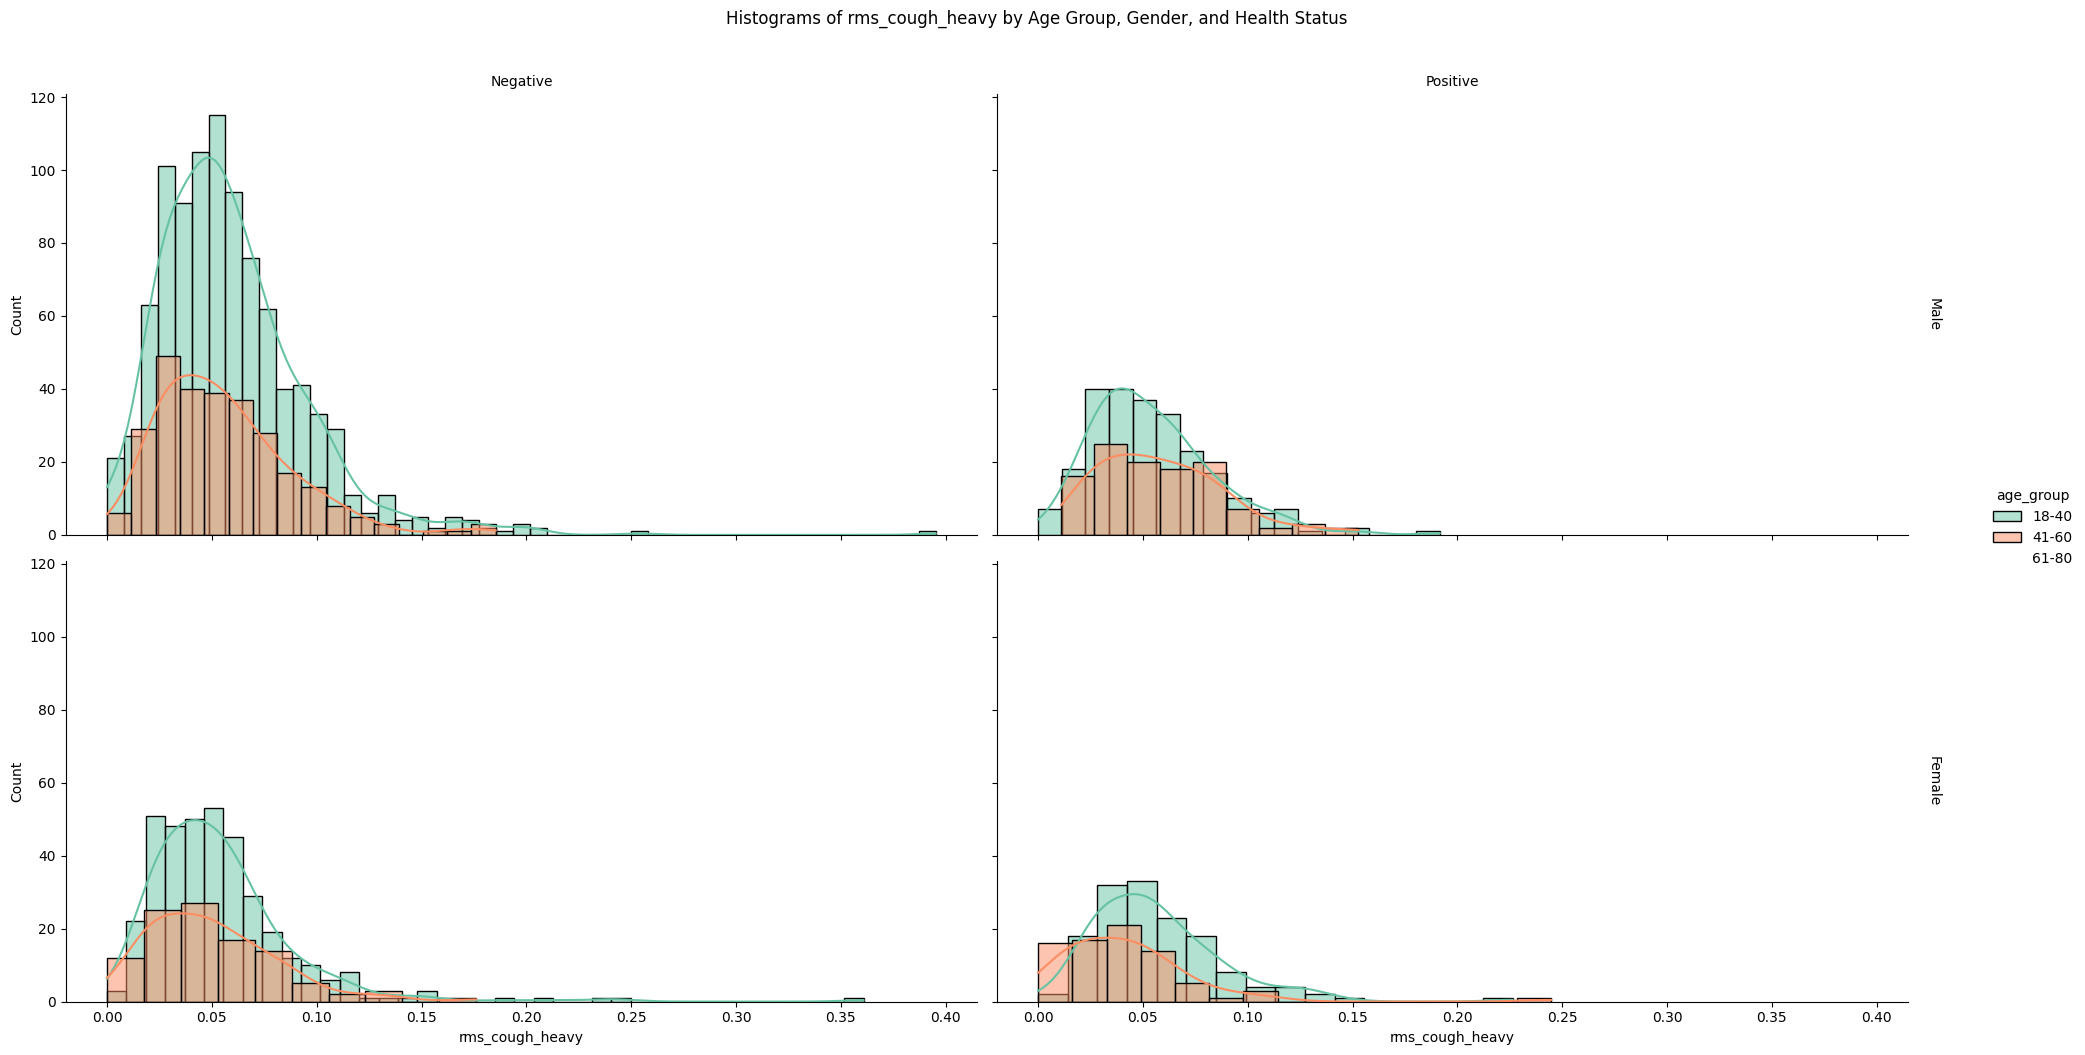

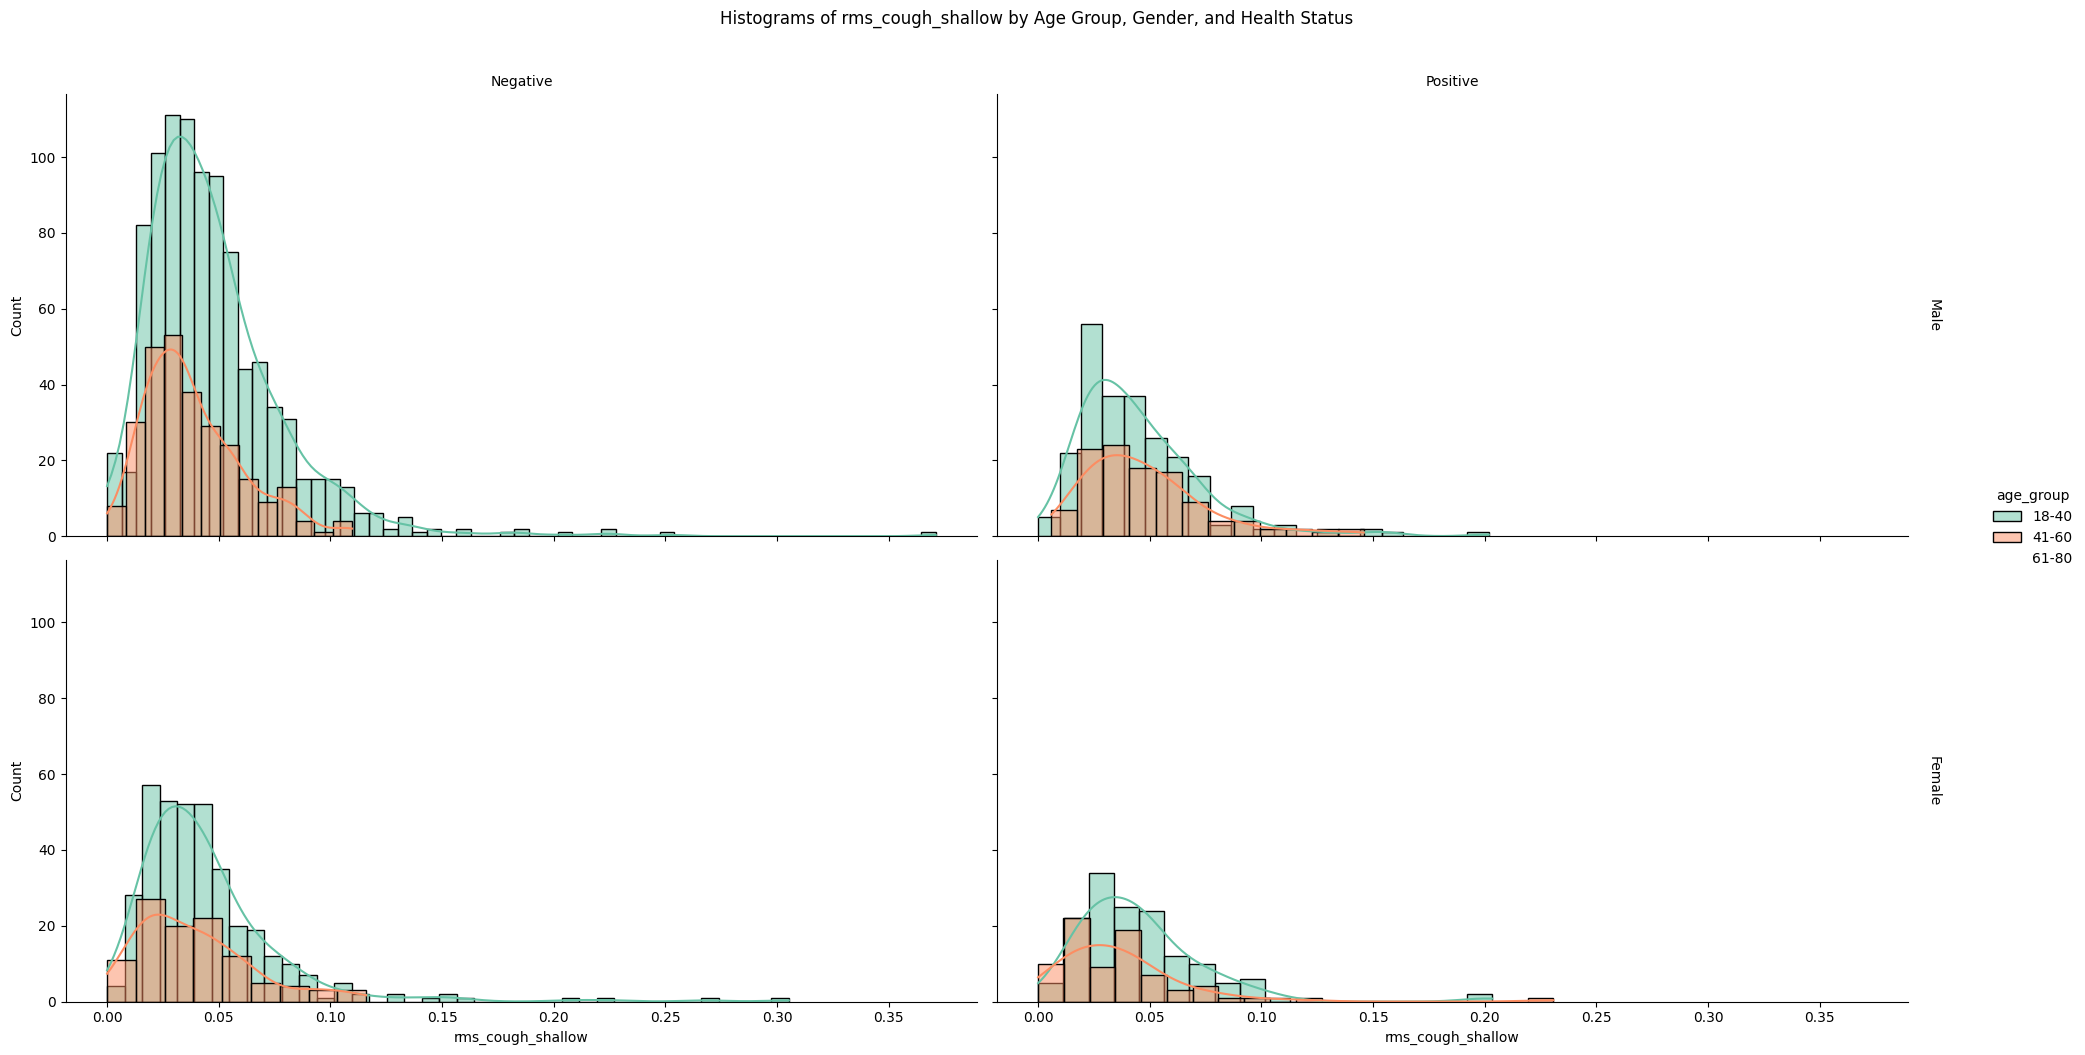

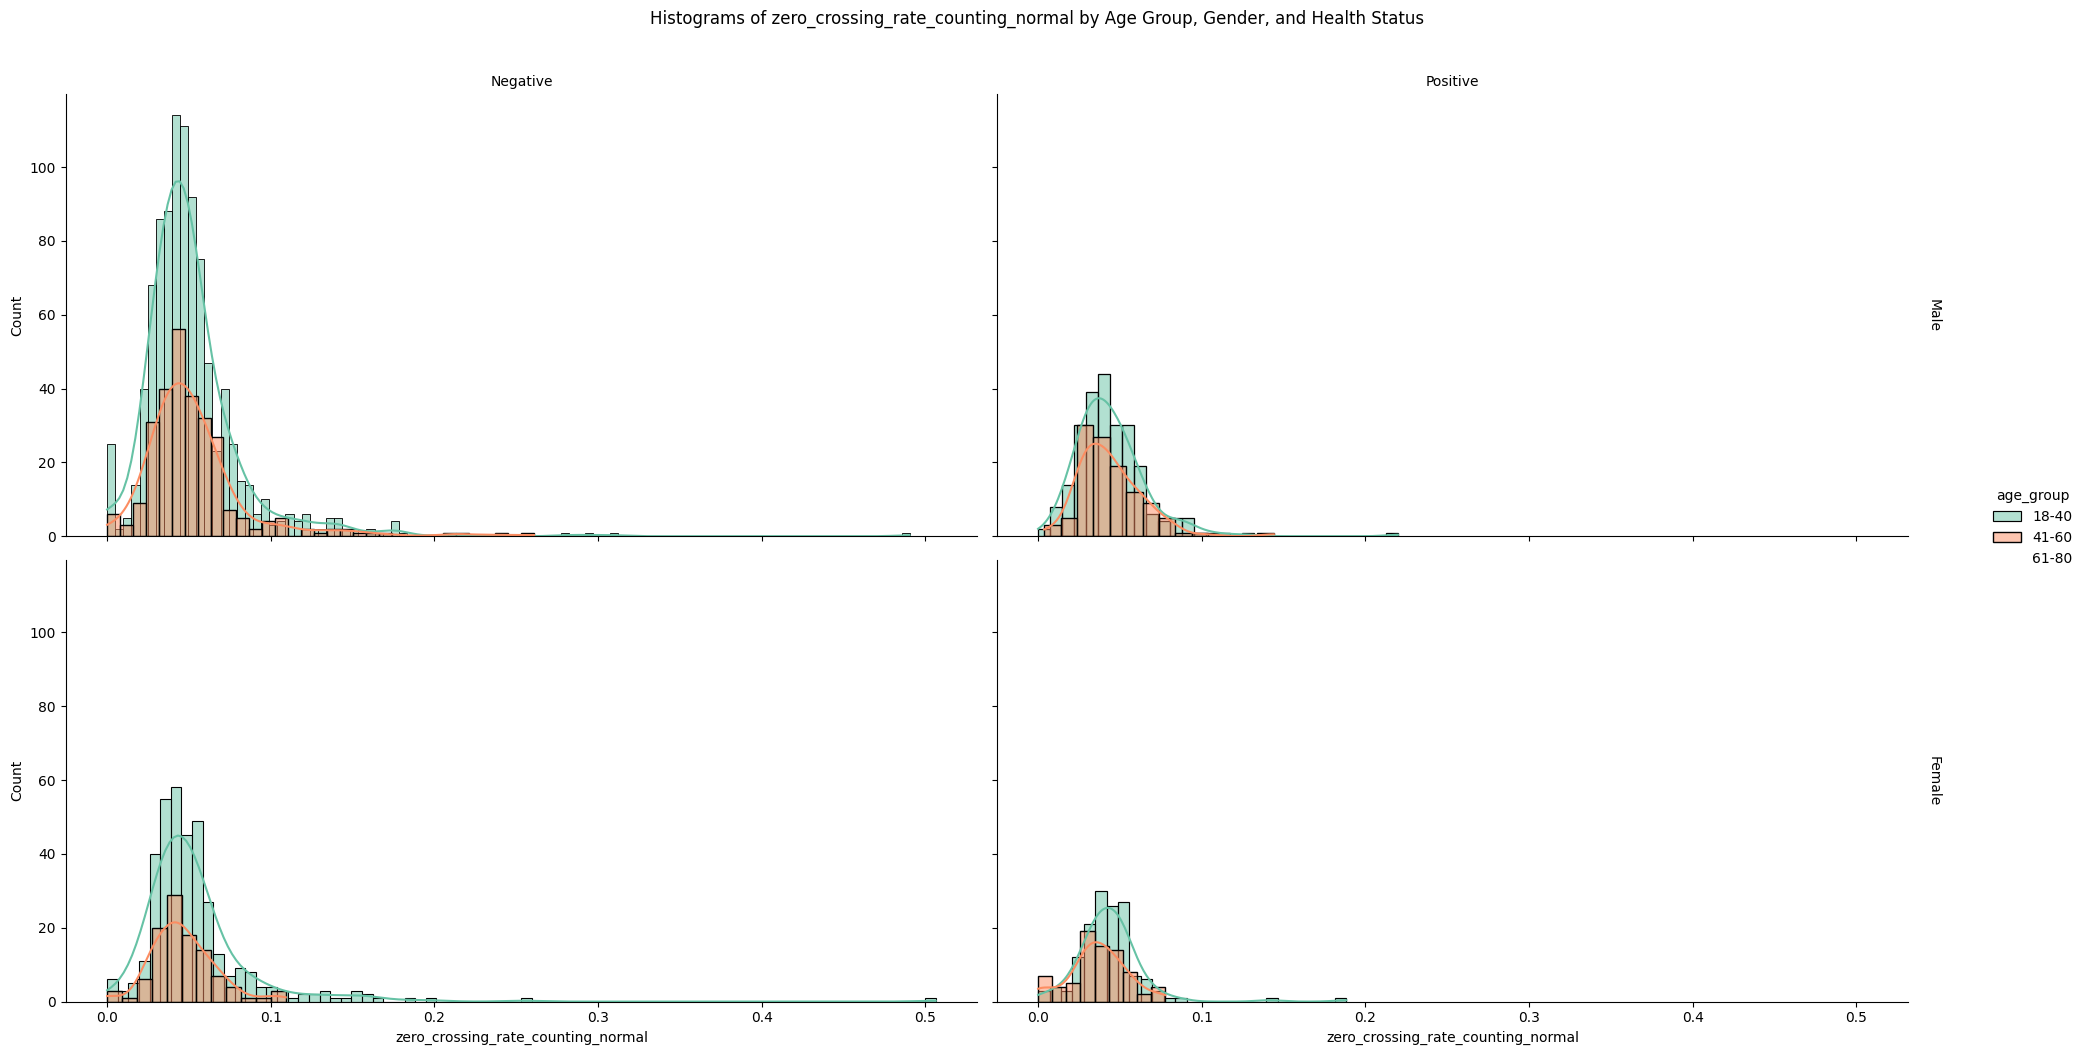

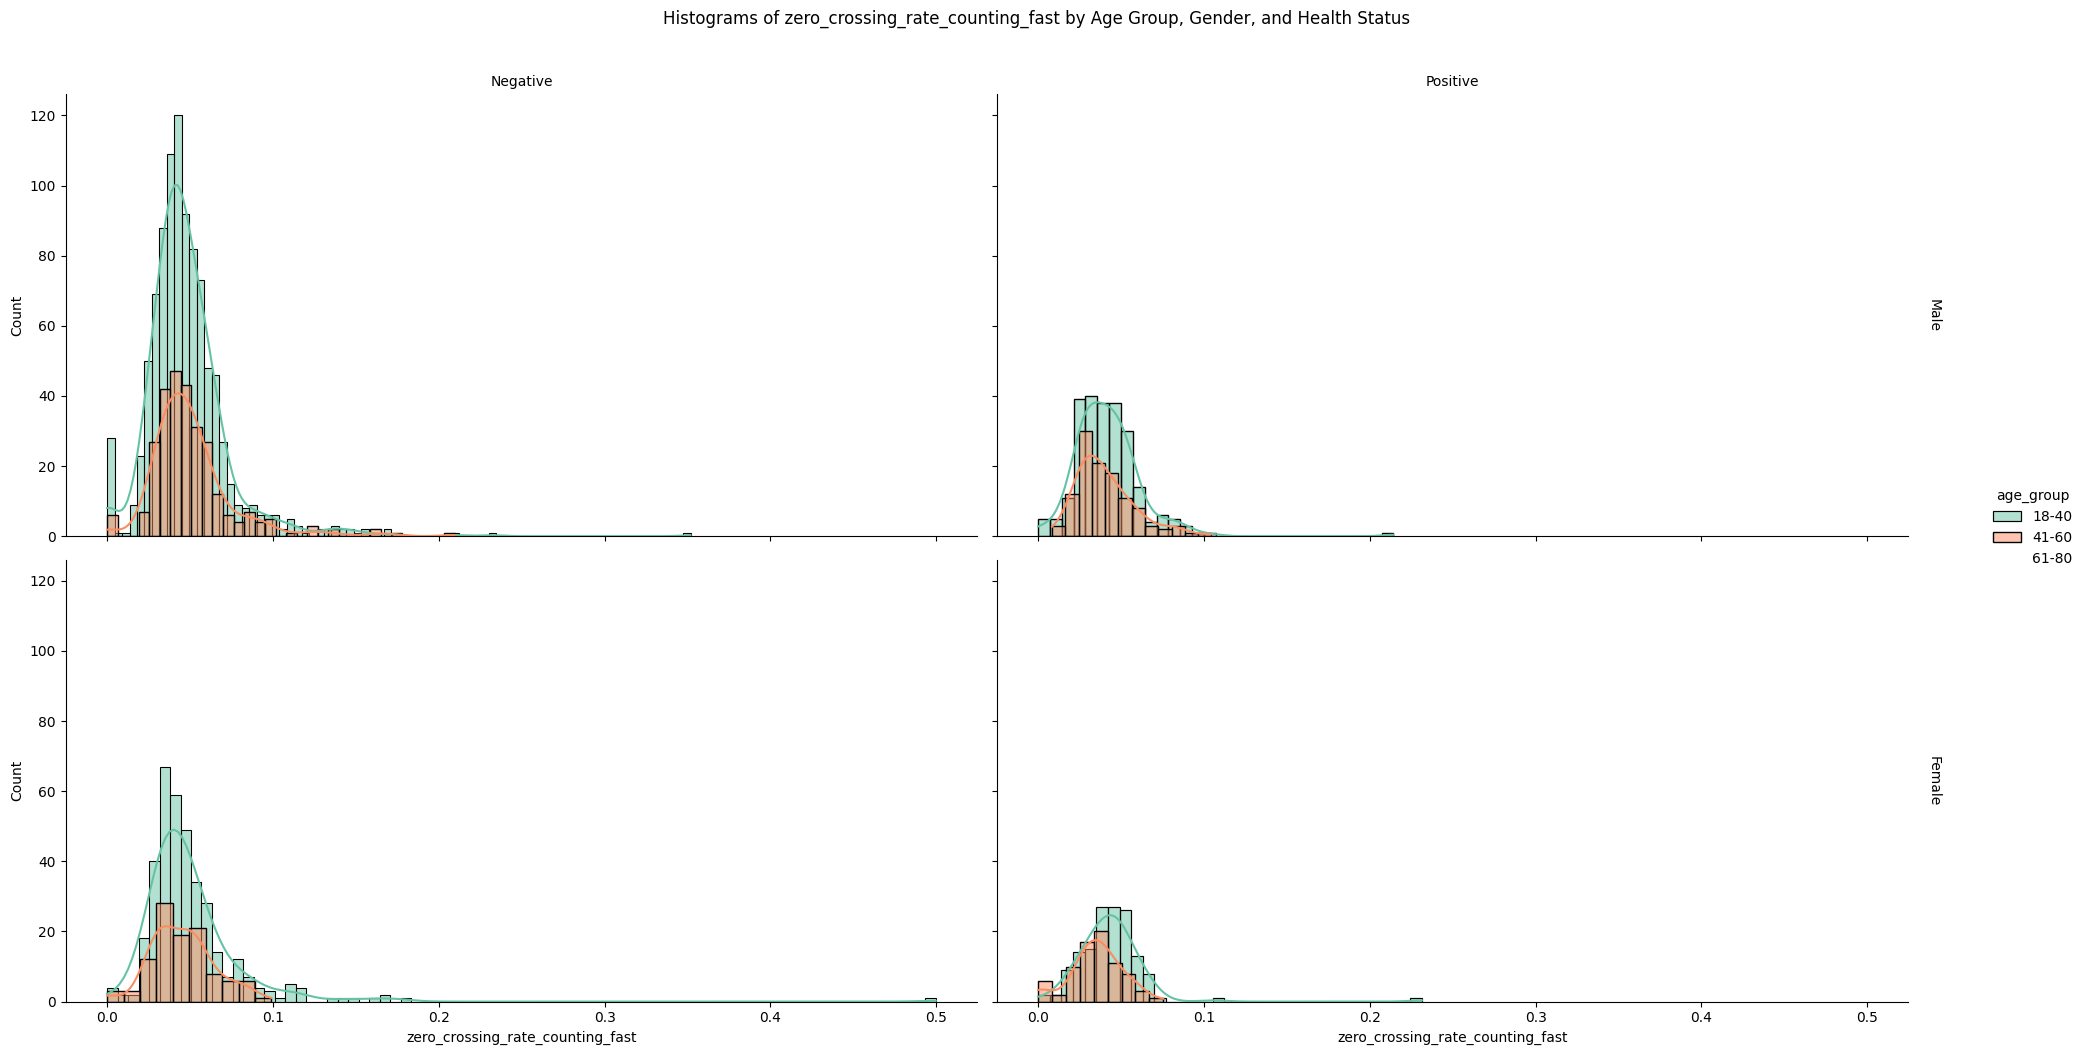

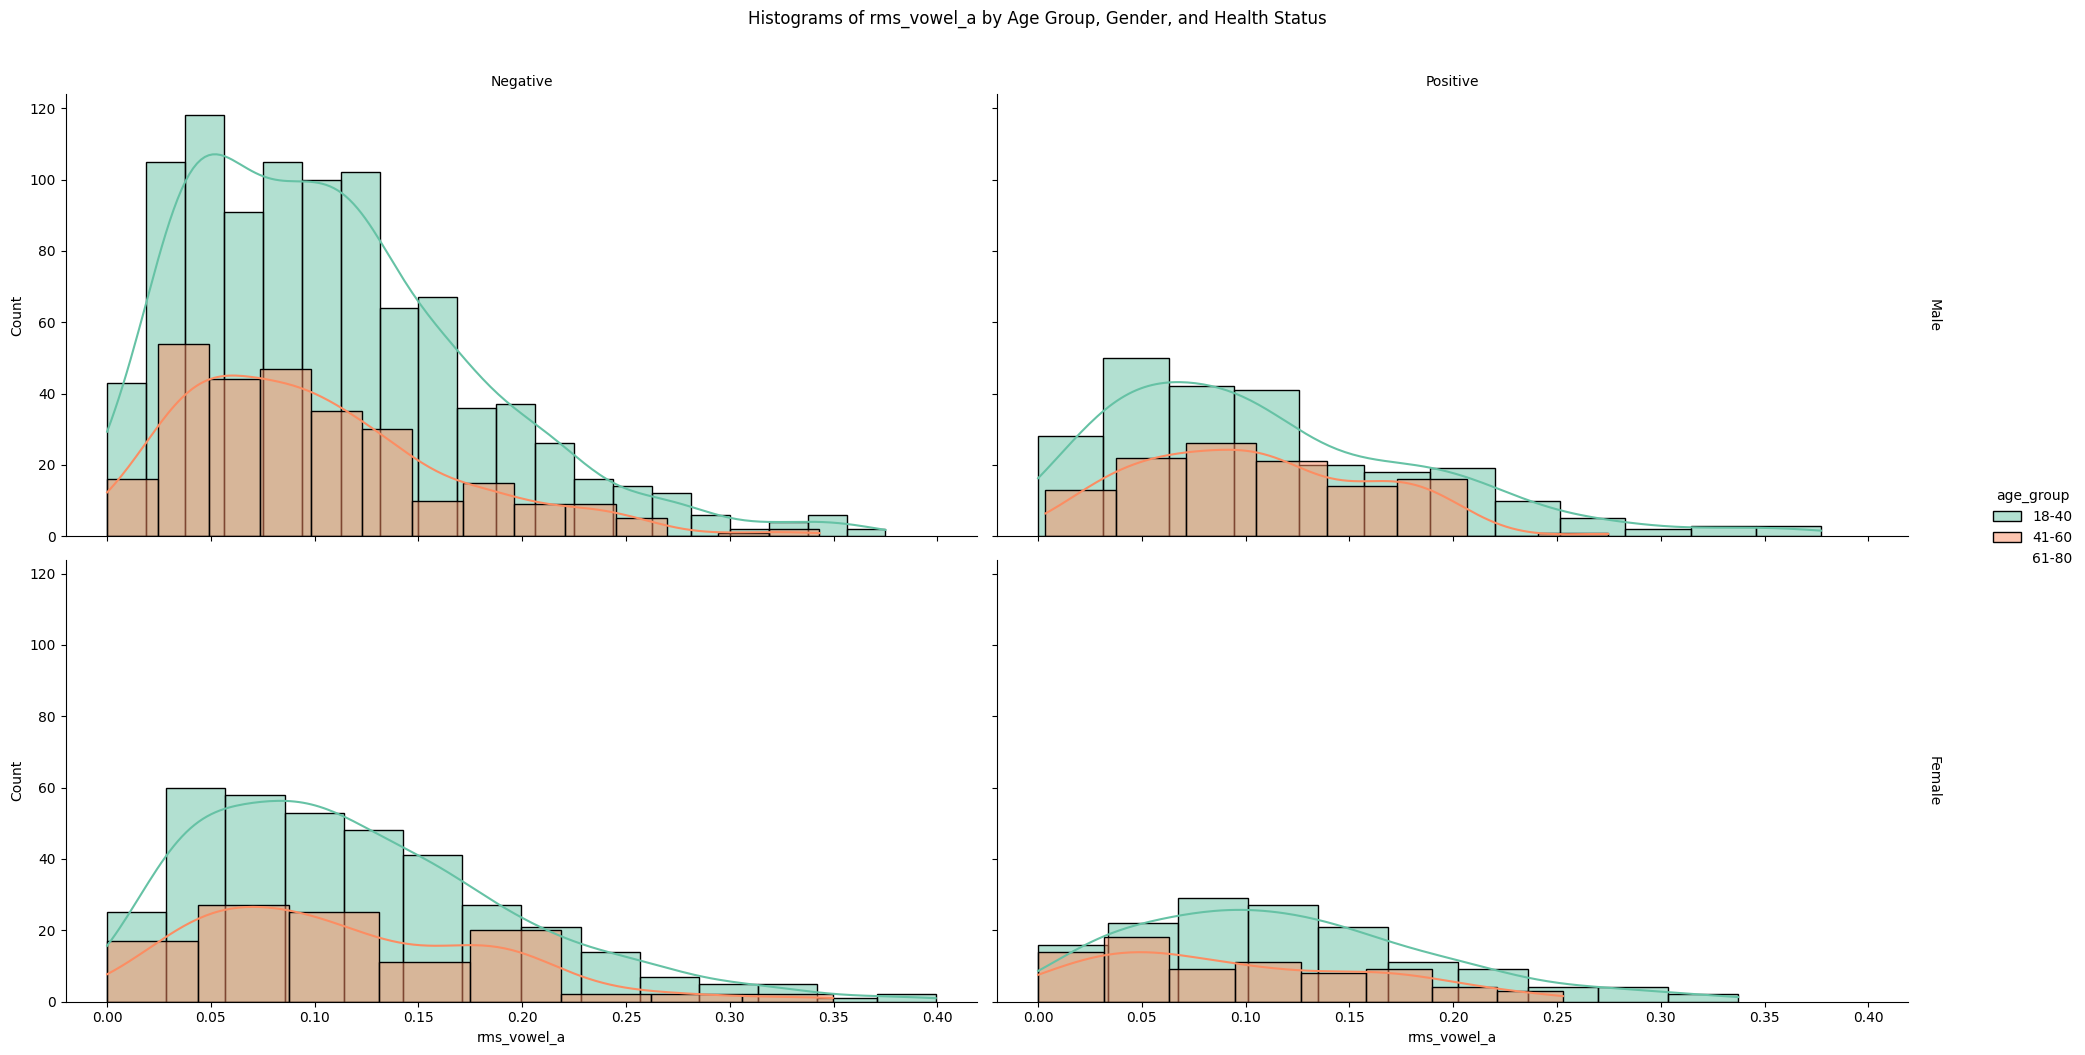

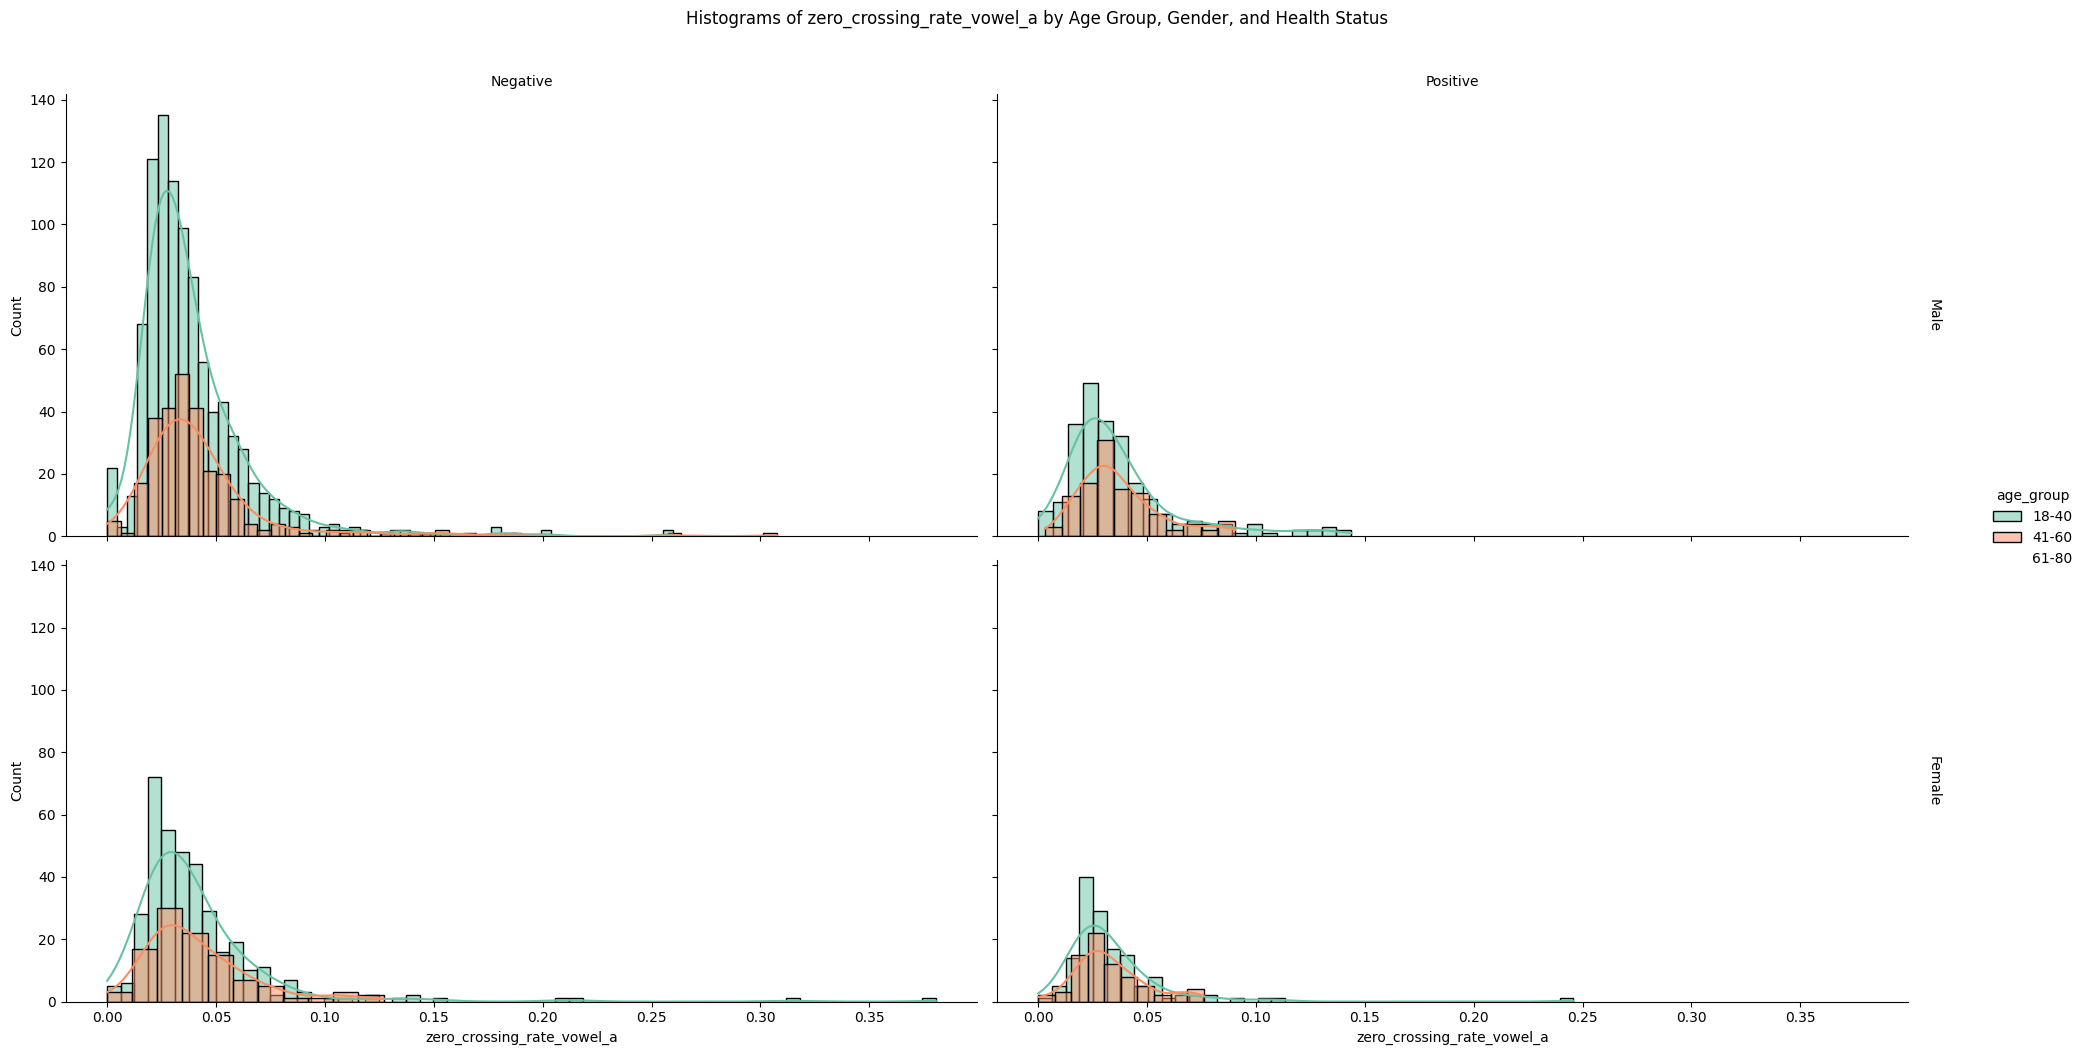

In [347]:
important_columns = ['rms_cough_heavy','rms_cough_shallow','zero_crossing_rate_counting_normal','zero_crossing_rate_counting_fast','rms_vowel_a','zero_crossing_rate_vowel_a']

def plot_facet_grid(col):
    g = sns.FacetGrid(data, col="health_status", row="gender", hue="age_group", margin_titles=True, height=5, aspect=2, palette="Set2")
    g.map(sns.histplot, col, kde=True, multiple='stack').add_legend()
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels(col, "Count")
    g.fig.suptitle(f'Histograms of {col} by Age Group, Gender, and Health Status', y=1.05)
    plt.show()

for col in important_columns:
    plot_facet_grid(col)

The correlation matrix

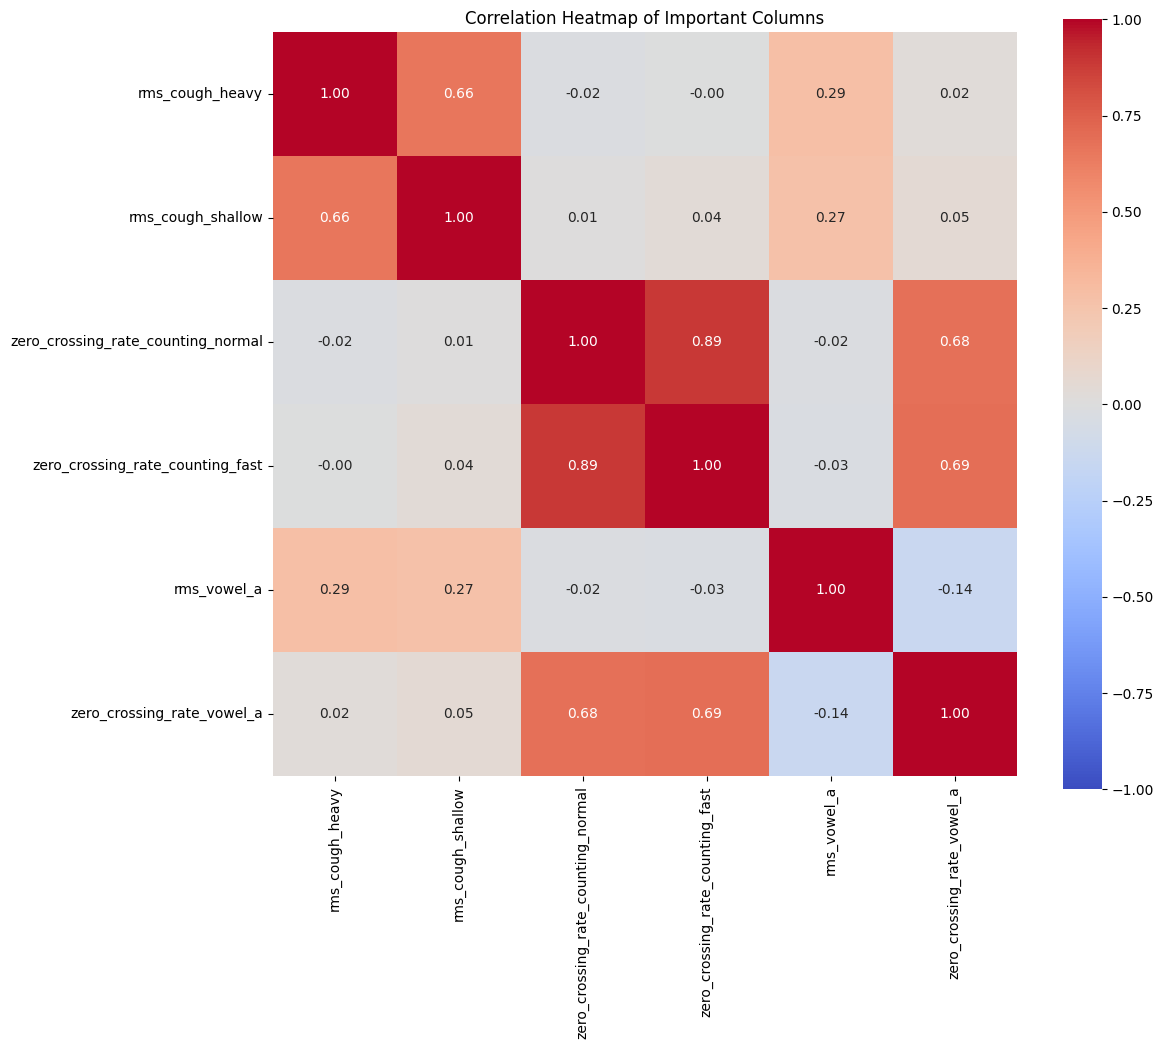

In [348]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data[important_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, center=0, square=True)
plt.title('Correlation Heatmap of Important Columns')
plt.show()


## We used this code to get the plots for all the numericals coulmns, Did not run it beacsuse it takes a lot space

In [349]:
# # Function to create the FacetGrid
# def plot_facet_grid(col):
#     g = sns.FacetGrid(data, col="health_status", row="gender", hue="age_group", margin_titles=True, height=5, aspect=2, palette="Set2")
#     g.map(sns.histplot, col, kde=True, multiple='stack').add_legend()
#     g.set_titles(col_template="{col_name}", row_template="{row_name}")
#     g.set_axis_labels(col, "Count")
#     g.fig.suptitle(f'Histograms of {col} by Age Group, Gender, and Health Status', y=1.05)
#     plt.show()

# # Plot for each column
# for col in numerical_columns:
#     plot_facet_grid(col)

Running anova for all the numerical columns

In [350]:
for col in numerical_columns:
    formula = f'{col} ~ C(gender) + C(health_status) + C(age_group) + C(gender):C(health_status) + C(gender):C(age_group) + C(health_status):C(age_group) + C(gender):C(health_status):C(age_group)'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    significant_results = anova_table[anova_table['PR(>F)'] < 0.05]
    
    if not significant_results.empty:
        print('-' * len(f'ANOVA for {col}'))
        print(f'ANOVA for {col}')
        print(significant_results)
        print('\n')

------------------------------
ANOVA for chroma_0_cough_heavy
                sum_sq   df        F   PR(>F)
C(age_group)  0.265613  2.0  9.11771  0.00256


------------------------------
ANOVA for chroma_1_cough_heavy
                sum_sq   df         F    PR(>F)
C(age_group)  0.231034  2.0  7.960743  0.004822


------------------------------
ANOVA for chroma_2_cough_heavy
                          sum_sq   df        F    PR(>F)
C(age_group)            0.244419  2.0  8.28680  0.004031
C(gender):C(age_group)  0.115374  2.0  3.91163  0.048073


------------------------------
ANOVA for chroma_3_cough_heavy
               sum_sq   df         F    PR(>F)
C(age_group)  0.16356  2.0  5.765067  0.016428


------------------------------
ANOVA for chroma_7_cough_heavy
                sum_sq   df         F    PR(>F)
C(age_group)  0.166546  2.0  5.336736  0.020969


------------------------------
ANOVA for chroma_8_cough_heavy
                sum_sq   df         F    PR(>F)
C(age_group)  0.22752